---
title: "Evaluacion del rendimiento de modelos"
date: 2022-05-03T17:30:50+02:00
tags: [dummy, baseline, kfold, stratification, estratificación, ShuffleSplit, accuracy, precision, recall, AUC, ROC AUC, sensibilidad, especificidad, R2]
categories: [tutoriales]
---

En anteriores posts vimos el framework general de validación cruzada y su uso para evaluar el rendimiento de modelos. Sin embargo, es importante tener en cuenta que algunos elementos de la validación cruzada deben decidirse en función de la naturaleza del problema: (i) la estrategia de validación cruzada y (ii) las métricas de evaluación. Además, siempre es bueno comparar el rendimiento de los modelos respecto de alguna línea base.

En este post presentaremos ambos aspectos y ofreceremos intuiciones e ideas de cuándo usar una estrategia de validación cruzada y métrica específicas. Además, también daremos algunas ideas sobre cómo comparar un modelo con alguna línea base.

Como objetivos generales intentaremos:

+ comprender la necesidad de usar una estrategia adecuada de validación cruzada dependiendo de los datos;
+ obtener las intuiciones y principios que hay detrás del uso de la validación cruzada anidada cuando el modelo necesita ser evaluado y optimizado;
+ comprender las diferencias entre las métricas de regresión y clasificación;
+ comprender las diferencias entre métricas.

# Comparación del rendimiento del modelo con una línea base simple

Vamos a ver cómo comparar el rendimiento de generalización de un modelo con una mínima linea base. En regresión, podemos usar la clase `DummyRegressor` para predecir el valor medio del objetivo observado en el conjunto de entrenamiento sin usar las variables de entrada.

Demostraremos cómo calcular la puntuación de un modelo de regresión y compararlo con una línea base en el dataset de viviendas de California.

In [1160]:
from sklearn.datasets import fetch_california_housing

X, y = fetch_california_housing(return_X_y=True, as_frame=True)
y *= 100  # reescala el objetivo en k$

En todas las evaluaciones usaremos un divisor de validación cruzada `ShuffleSplit` con el 20% de los datos reservados para validación.

In [1161]:
from sklearn.model_selection import ShuffleSplit

cv = ShuffleSplit(n_splits=30, test_size=0.2, random_state=0)

Empezaremos ejecutando la validación cruzada para un simple árbol de decisión regresor, que es nuestro modelo de interés. Además, almacenaremos el error de prueba en un objeto Series de pandas para hacer más sencillo dibujar los resultados.

In [1162]:
import pandas as pd
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import cross_validate

regressor = DecisionTreeRegressor()
cv_results_tree_regressor = cross_validate(
    regressor, X, y, cv=cv, scoring="neg_mean_absolute_error", n_jobs=-1
)

errors_tree_regressor = pd.Series(
    -cv_results_tree_regressor["test_score"], name="Arbol decisión regresor"
)
errors_tree_regressor.describe()

count    30.000000
mean     45.641306
std       1.249005
min      43.111065
25%      44.691150
50%      45.586332
75%      46.640596
max      47.711138
Name: Arbol decisión regresor, dtype: float64

Luego, evaluamos nuestra línea base.  Esta línea base se denomina regresor dummy. Este regresor dummy siempre predecirá la media del objetivo calculada en la variable objetivo de entrenamiento. Por lo tanto, el regresor dummy no usa ninguna información de las variables de entrada almacenadas en el dataframe llamado `X`.

In [1163]:
from sklearn.dummy import DummyRegressor

dummy = DummyRegressor(strategy="mean")
result_dummy = cross_validate(
    dummy, X, y, cv=cv, scoring="neg_mean_absolute_error", n_jobs=-1
)
errors_dummy_regressor = pd.Series(
    -result_dummy["test_score"], name="Regresor dummy"
)
errors_dummy_regressor.describe()

count    30.000000
mean     91.140009
std       0.821140
min      89.757566
25%      90.543652
50%      91.034555
75%      91.979007
max      92.477244
Name: Regresor dummy, dtype: float64

Ahora dibujaremos los errores de prueba de la validación cruzada para la línea base usando la media del objetivo y el actual árbol de decisión regresor.

In [1164]:
all_errors = pd.concat(
    [errors_tree_regressor, errors_dummy_regressor],
    axis=1,
)
all_errors

,Arbol decisión regresor,Regresor dummy
0,47.156293,90.713153
1,46.491834,90.539353
2,43.960410,91.941912
3,43.343595,90.213912
4,47.711138,92.015862
5,44.960189,90.542490
6,44.180467,89.757566
7,44.498127,92.477244
8,45.463726,90.947952
9,45.048634,91.991373


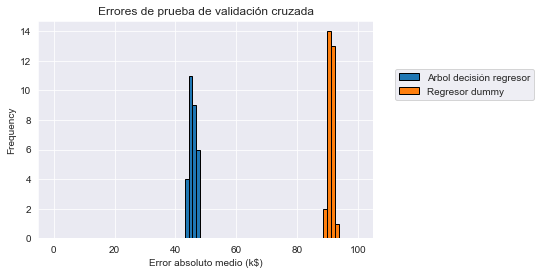

In [1165]:
import matplotlib.pyplot as plt
import numpy as np

bins = np.linspace(start=0, stop=100, num=80)
all_errors.plot.hist(bins=bins, edgecolor="black")
plt.legend(bbox_to_anchor=(1.05, 0.8), loc="upper left")
plt.xlabel("Error absoluto medio (k$)")
_ = plt.title("Errores de prueba de validación cruzada")

Vemos que el rendimiento de generalización de nuestro ábol de decisión está lejos de ser perfecto: las predicciones del precio tiene aproximadamente un márgen de error de 45000 dólares de media. Sin embargo, es mucho mejor que el margen de error de la línea base. Por tanto, esto confirma que es posible predecir mucho mejor el precio de la vivienda usando un modelo que tenga en cuenta los valores de las variables de entrada (localización de la propiedad, tamaño, ingresos del vecindario, etc.). Dicho modelo hace predicciones más formadas y, aproximadamente, divide la tasa de error por la mitad comparado con la línea base que ignora las variables de entrada.

Observemos que hemos usado la media del precio como predicción de línea base. Podríamos haber usado en su lugar la mediana. Véase la documentación online de la clase [`sklearn.dummy.DummyRegressor`](https://scikit-learn.org/stable/modules/generated/sklearn.dummy.DummyRegressor.html) para otras opciones. Para este ejemplo en particular, no existe mucha diferencia entre usar la media en lugar de la mediana, pero este podría ser el caso de un dataset con valores atípicos extremos.

## Ejercicio

Vamos a poner en práctica lo aprendido hasta ahora. Definiremos una línea base con un clasificador dummy y lo usaremos como referencia para evaluar el rendimiento predictivo relativo de un modelo de interés dado.

Ilustraremos dicha línea base con la ayuda del dataset del censo de adultos, usando únicamente las variables numéricas, por simplicidad.

In [1166]:
adult_census = pd.read_csv("../data/adult-census-numeric-all.csv")
X, y = adult_census.drop(columns="class"), adult_census["class"]

Primero definiremos una estrategia de validación cruzada con `ShuffleSplit` tomando la mitad de las muestras como prueba en cada ciclo. Usaremos 10 ciclos de validación cruzada.

In [1167]:
cv = ShuffleSplit(n_splits=10, test_size=0.5, random_state=0)

Lo siguiente es crear un pipeline de machine learning compuesto por un transformador para estandarizar los datos seguido por un clasificador de regresión logística.

In [1168]:
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import make_pipeline

classifier = make_pipeline(StandardScaler(), LogisticRegression())


Calculemos ahora las puntuaciones de prueba de validación cruzada para el clasificador en este dataset y almacenaremos los resultados en una Series de panda.

In [1169]:
from sklearn.model_selection import cross_validate

cv_results_logistic_regression = cross_validate(
    classifier, X, y, cv=cv, n_jobs=-1)

test_score_logistic_regression = pd.Series(
    cv_results_logistic_regression["test_score"], name="Regresión logística"
)
test_score_logistic_regression

0    0.815937
1    0.813849
2    0.815036
3    0.815569
4    0.810982
5    0.814709
6    0.813112
7    0.810327
8    0.812416
9    0.816388
Name: Regresión logística, dtype: float64

Ahora calcularemos las puntuaciones de validación cruzada de un clasificador dummy que prediga constantemente la clase más frecuente observada en el conjunto de entrenamiento. Almacenaremos los resultados en un Series de panda.

In [1170]:
from sklearn.dummy import DummyClassifier

dummy_most_frequent = DummyClassifier(strategy="most_frequent")
result_dummy = cross_validate(
    dummy_most_frequent, X, y, cv=cv, n_jobs=-1
)
test_dummy_most_frequent = pd.Series(
    result_dummy["test_score"], name="Most-frequent dummy"
)
test_dummy_most_frequent

0    0.760329
1    0.756808
2    0.759142
3    0.760739
4    0.761681
5    0.761885
6    0.757463
7    0.757176
8    0.761885
9    0.763114
Name: Most-frequent dummy, dtype: float64

Ahora que hemos recopilado los resultados tanto de la línea base como del modelo, vamos a concatenar las puntuaciones de prueba como columnas en un dataframe de pandas.

In [1171]:
all_scores = pd.concat(
    [test_score_logistic_regression, test_dummy_most_frequent],
    axis=1,
)
all_scores

,Regresión logística,Most-frequent dummy
0,0.815937,0.760329
1,0.813849,0.756808
2,0.815036,0.759142
3,0.815569,0.760739
4,0.810982,0.761681
5,0.814709,0.761885
6,0.813112,0.757463
7,0.810327,0.757176
8,0.812416,0.761885
9,0.816388,0.763114


Lo siguiente que haremos será dibujar el histograma de las puntuaciones de prueba de validación cruzada para ambos modelos con la ayuda de la [función de dibujado incorporada en pandas](https://pandas.pydata.org/pandas-docs/stable/user_guide/visualization.html#histograms). ¿Qué conclusiones obtenemos de los resultados?

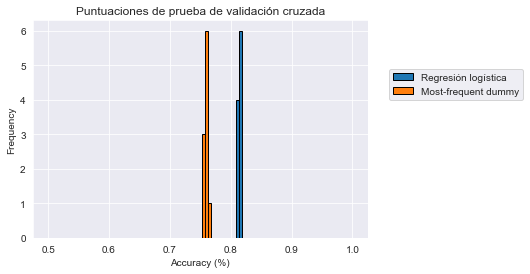

In [1172]:
import matplotlib.pyplot as plt
import numpy as np

bins = np.linspace(start=0.5, stop=1.0, num=100)
all_scores.plot.hist(bins=bins, edgecolor="black")
plt.legend(bbox_to_anchor=(1.05, 0.8), loc="upper left")
plt.xlabel("Accuracy (%)")
_ = plt.title("Puntuaciones de prueba de validación cruzada")

Observamos que los dos histogramas están bien separados. Por lo tanto el clasificador dummy con la estrategia `most_frequent` tiene mucha menos precisión que el clasificador de regresión logística. Podemos concluir que el modelo de regresión logística puede encontrar satisfactoriamente información predictiva en las variables de entrada para mejorar la línea base.

Por último, vamos a cambiar la estrategia del clasificador dummy a `"stratified"` y calcularemos los resultados. De igual forma, calcularemos las puntuaciones para la `strategy="uniform"` y después dibujaremos la distribución conjuntamente con los otros resultados.

¿Estas nuevas líneas base son mejores que la previa? ¿Por qué es este el caso?

Podemos consultar la documentación de [`sklearn.dummy.DummyClassifier`](https://scikit-learn.org/stable/modules/generated/sklearn.dummy.DummyClassifier.html) para conocer el significado de estas estrategias.

In [1173]:
dummy_stratified = DummyClassifier(strategy="stratified")
result_dummy_stratified = cross_validate(
    dummy_stratified, X, y, cv=cv, n_jobs=-1
)
test_dummy_stratified = pd.Series(
    result_dummy_stratified["test_score"], name="Stratified dummy"
)
test_dummy_stratified

0    0.638590
1    0.640596
2    0.636133
3    0.634085
4    0.634085
5    0.634126
6    0.632652
7    0.638016
8    0.639327
9    0.635027
Name: Stratified dummy, dtype: float64

In [1174]:
dummy_uniform = DummyClassifier(strategy="uniform")
result_dummy_uniform = cross_validate(
    dummy_uniform, X, y, cv=cv, n_jobs=-1
)
test_dummy_uniform = pd.Series(
    result_dummy_uniform["test_score"], name="Uniform dummy"
)
test_dummy_uniform

0    0.502477
1    0.505426
2    0.505549
3    0.501003
4    0.503911
5    0.497318
6    0.501413
7    0.499775
8    0.500143
9    0.496171
Name: Uniform dummy, dtype: float64

In [1175]:
all_scores = pd.concat(
    [test_score_logistic_regression,
     test_dummy_most_frequent,
     test_dummy_stratified,
     test_dummy_uniform,],
    axis=1,
)
all_scores

,Regresión logística,Most-frequent dummy,Stratified dummy,Uniform dummy
0,0.815937,0.760329,0.638590,0.502477
1,0.813849,0.756808,0.640596,0.505426
2,0.815036,0.759142,0.636133,0.505549
3,0.815569,0.760739,0.634085,0.501003
4,0.810982,0.761681,0.634085,0.503911
5,0.814709,0.761885,0.634126,0.497318
6,0.813112,0.757463,0.632652,0.501413
7,0.810327,0.757176,0.638016,0.499775
8,0.812416,0.761885,0.639327,0.500143
9,0.816388,0.763114,0.635027,0.496171


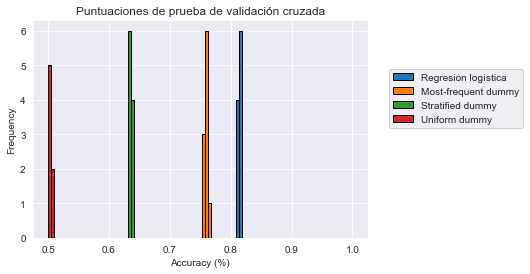

In [1176]:
bins = np.linspace(start=0.5, stop=1.0, num=100)
all_scores.plot.hist(bins=bins, edgecolor="black")
plt.legend(bbox_to_anchor=(1.05, 0.8), loc="upper left")
plt.xlabel("Accuracy (%)")
_ = plt.title("Puntuaciones de prueba de validación cruzada")

Vemos que al usar `strategy="stratified"` los resultados son mucho peores que con la estrategia `most_frequent`. Dado que las clases están desbalanceadas, predecir la más frecuente implica que acertaremos en la proporción de esa clase (aproximadamente el 75% de las muestras), es decir, el 75% de las veces. Sin embargo, la estrategia `"stratified"` generará predicciones aleatoriamente respetando la distribución de las clases del conjunto de entrenamiento, lo que dará como resultado algunas predicciones incorrectas, incluso para la clase más frecuente, por lo tanto obtenemos una precisión menor.

Esto es aún más cierto para `strategy="uniform"`: esta estrategia asigna etiquetas de clase uniformemente al azar. Por lo tanto, en un problema de clasificación binaria, la precisión de validación cruzada es del 50% de media, por lo cual es la más débil de las tres líneas base dummy.

Nota: se podría argumentar que las estrategias `"uniform"` y `"stratified"` son maneras válidas de definir un "nivel de aleatoriedad" de la precisión de una línea base para el problema de clasificación, debido a que hacen predicciones "al azar".

Otra forma de definir un nivel de azar podría ser usando la utilidad de scikit-learn [sklearn.model_selection.permutation_test_score](https://scikit-learn.org/stable/auto_examples/model_selection/plot_permutation_tests_for_classification.html). En lugar de usar un clasificador dummy, esta función compara la precisión de validación cruzada de un modelo de interés con la precisión de validación cruzada de este mismo modelo pero entrenado en etiquetas de clase permutadas aleatoriamente. Por lo tanto, `permutation_test_score` define un nivel de azar que depende de la elección de la clase y los hiperparámetros del estimador de interés. Cuando entrenamos en tales etiquetas permutadas aleatoriamente, muchos estimadores de machine learning terminan comportándose aproximadamente como `DummyClassifier(strategy="most_frequent")`, prediciendo siempre la clase mayoritaria, independientemente de las variables de entrada. Como resultado, esta línea base `most_frequent` se llama algunas veces "nivel de azar" para problemas de clasificación desbalanceados, aunque sus predicciones son completamente deterministas y no involucran mucho azar.

Definir el nivel de azar usando `permutation_test_score` es bastante costoso computacionalmente, debido a que requiere entrenar muchos modelos no dummys en permutaciones aleatorias de los datos. Usar clasificadores dummys como líneas base suele ser suficiente para fines prácticos. Para problemas de clasificacion desbalanceados, la estrategia `most_frequent` es la más fuerte de las tres líneas bases y por tanto la que debemos usar.

# Elección de validación cruzada

## Estratificación

Generalmente hemos usado por defecto una estrategia de validación cruzada `KFold` o `ShuffleSplit` para dividir de forma iterativa nuestro dataset. Sin embargo, no debemos asumir que estos enfoques son siempre la mejor opción: otras estrategias de validación cruzada podrían adaptarse mejor a nuestro problema.

Comencemos con el concepto de estratificación, dando un ejemplo donde podemos tener problemas si no somos cuidadosos. Carguemos el dataset iris.

In [1177]:
from sklearn.datasets import load_iris

X, y = load_iris(as_frame=True, return_X_y=True)

Vamos a crear un modelo de machine learning básico: una regresión logística. Esperamos que este modelo funcione bastante bien en el dataset iris, ya que es un dataset bastante simple.

In [1178]:
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(), LogisticRegression())

Una vez que hemos creado nuestro modelo, usaremos validación cruzada para evaluarlo. Usaremos la estrategia `KFold`. Definiremos un dataset con nueve muestras y repetiremos la validación cruzada tres veces (es decir, `n_splits`).

In [1179]:
import numpy as np
from sklearn.model_selection import KFold

X_random = np.random.randn(9, 1)
cv = KFold(n_splits=3)
for train_index, test_index in cv.split(X_random):
    print(f"ENTRENAMIENTO: {train_index}  PRUEBA: {test_index}")

ENTRENAMIENTO: [3 4 5 6 7 8]  PRUEBA: [0 1 2]
ENTRENAMIENTO: [0 1 2 6 7 8]  PRUEBA: [3 4 5]
ENTRENAMIENTO: [0 1 2 3 4 5]  PRUEBA: [6 7 8]


Al definir tres divisiones, usaremos tres muestras para prueba y seis para entrenamiento cada vez. `KFold` por defecto no baraja. Lo que significa que seleccionará las tres primeras muestras para el conjunto de prueba en la primera división, luego las tres siguientes muestras para la segunda división y las siguientes tres para la última división. Al final, todas las muestras se habrán usado en la prueba al menos una vez entre las diferentes divisiones.

Ahora  vamos a aplicar esta estrategia para verificar el rendimiento de generalización de nuestro modelo.

In [1180]:
from sklearn.model_selection import cross_validate

cv = KFold(n_splits=3)
results = cross_validate(model, X, y, cv=cv)
test_score = results["test_score"]
print(f"La precisión media es: "
      f"{test_score.mean():.3f} +/- {test_score.std():.3f}")

La precisión media es: 0.000 +/- 0.000


Es una sorpresa real que nuestro modelo no pueda clasificar correctamente ninguna muestra en ninguna división de validación cruzada. Comprobemos nuestros valores de objetivo para comprender el problema.

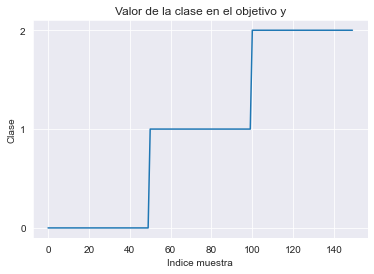

In [1181]:
import matplotlib.pyplot as plt

y.plot()
plt.xlabel("Indice muestra")
plt.ylabel("Clase")
plt.yticks(y.unique())
_ = plt.title("Valor de la clase en el objetivo y")

Vemos que el vector objetivo `y` está ordenado. Tendrá algunas consecuencias inesperadas cuando usemos la validación cruzada `KFold`. Para ilustrar las consecuencias, mostraremos el recuento de clases en cada partición de la validación cruzada en los conjuntos de entrenamiento y prueba y dibujaremos esta información en un barplot.

In [1182]:
import pandas as pd

n_splits = 3
cv = KFold(n_splits=n_splits)

train_cv_counts = []
test_cv_counts = []
for fold_idx, (train_idx, test_idx) in enumerate(cv.split(X, y)):
    y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]

    train_cv_counts.append(y_train.value_counts())
    test_cv_counts.append(y_test.value_counts())

In [1183]:
train_cv_counts = pd.concat(train_cv_counts, axis=1,
                            keys=[f"Partición #{idx}" for idx in range(n_splits)])
train_cv_counts.index.name = "Etiqueta clase"
train_cv_counts

,Partición #0,Partición #1,Partición #2
Etiqueta clase,,,
1,50.0,NaN,50.0
2,50.0,50.0,NaN
0,NaN,50.0,50.0


In [1184]:
test_cv_counts = pd.concat(test_cv_counts, axis=1,
                           keys=[f"Partición #{idx}" for idx in range(n_splits)])
test_cv_counts.index.name = "Etiqueta  clase"
test_cv_counts

,Partición #0,Partición #1,Partición #2
Etiqueta clase,,,
0,50.0,NaN,NaN
1,NaN,50.0,NaN
2,NaN,NaN,50.0


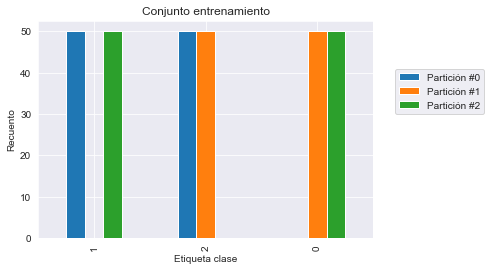

In [1185]:
train_cv_counts.plot.bar()
plt.legend(bbox_to_anchor=(1.05, 0.8), loc="upper left")
plt.ylabel("Recuento")
_ = plt.title("Conjunto entrenamiento")

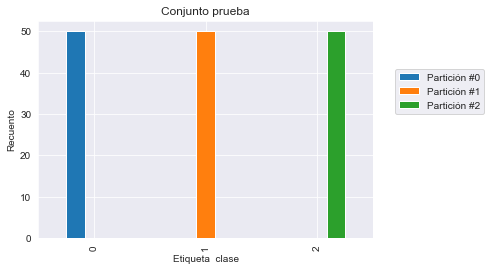

In [1186]:
test_cv_counts.plot.bar()
plt.legend(bbox_to_anchor=(1.05, 0.8), loc="upper left")
plt.ylabel("Recuento")
_ = plt.title("Conjunto prueba")

Podemos confirmar que en cada partición del conjunto de entrenamiento solo están presentes dos de las tres clases y todas las muestras de la clase restante se usan como conjunto de prueba. Por tanto, nuestro modelo es incapaz de predecir esta clase que no ha sido visto nunca durante la fase de entrenamiento.

Una posibilidad para resolver este problema es barajar los datos antes de dividirlos en los tres grupos.

In [1187]:
cv = KFold(n_splits=3, shuffle=True, random_state=0)
results = cross_validate(model, X, y, cv=cv)
test_score = results["test_score"]
print(f"La precisión media es: "
      f"{test_score.mean():.3f} +/- {test_score.std():.3f}")

La precisión media es: 0.953 +/- 0.009


Obtenemos un resultado que está más cercano a lo se podría esperar con una precisión por encima del 90%. Ahora que hemos resulto nuestro primer problema, podría ser interesante comprobar si la frecuencia de clases en el conjunto de entrenamiento y prueba son iguales que las de nuestro dataset original. Aseguraría que estamos entrenando y probando nuestro modelo con una distribución de clases que encontaremos en producción.

In [1188]:
train_cv_counts = []
test_cv_counts = []
for fold_idx, (train_idx, test_idx) in enumerate(cv.split(X, y)):
    y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]

    train_cv_counts.append(y_train.value_counts())
    test_cv_counts.append(y_test.value_counts())
train_cv_counts = pd.concat(train_cv_counts, axis=1,
                            keys=[f"Partición #{idx}" for idx in range(n_splits)])
test_cv_counts = pd.concat(test_cv_counts, axis=1,
                           keys=[f"Partición #{idx}" for idx in range(n_splits)])
train_cv_counts.index.name = "Etiqueta clase"
test_cv_counts.index.name = "Etiqueta clase"

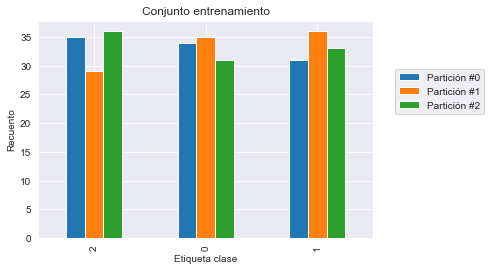

In [1189]:
train_cv_counts.plot.bar()
plt.legend(bbox_to_anchor=(1.05, 0.8), loc="upper left")
plt.ylabel("Recuento")
_ = plt.title("Conjunto entrenamiento")

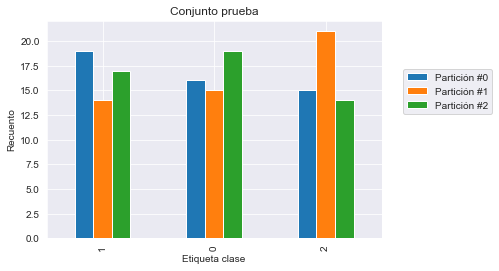

In [1190]:
test_cv_counts.plot.bar()
plt.legend(bbox_to_anchor=(1.05, 0.8), loc="upper left")
plt.ylabel("Recuento")
_ = plt.title("Conjunto prueba")

Vemos que ni el conjunto de entrenamiento ni el de prueba tienen las mismas frecuencias de clase que nuestro dataset original debido a que el recuento de cada clase varía un poco.

Sin embargo, podríamos querer dividir nuestros datos preservando las frecuencias de clase originales: queremos **estratificar** nuestros datos por clase. En scikit-learn, algunas estrategias de validación cruzada implementan la estratificación; contienen `Stratified` en sus nombres.

In [1191]:
from sklearn.model_selection import StratifiedKFold

cv = StratifiedKFold(n_splits=3)

In [1192]:
results = cross_validate(model, X, y, cv=cv)
test_score = results["test_score"]
print(f"La precisión media es: "
      f"{test_score.mean():.3f} +/- {test_score.std():.3f}")

La precisión media es: 0.960 +/- 0.016


In [1193]:
train_cv_counts = []
test_cv_counts = []
for fold_idx, (train_idx, test_idx) in enumerate(cv.split(X, y)):
    y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]

    train_cv_counts.append(y_train.value_counts())
    test_cv_counts.append(y_test.value_counts())
train_cv_counts = pd.concat(train_cv_counts, axis=1,
                            keys=[f"Partición #{idx}" for idx in range(n_splits)])
test_cv_counts = pd.concat(test_cv_counts, axis=1,
                           keys=[f"Partición #{idx}" for idx in range(n_splits)])
train_cv_counts.index.name = "Etiqueta clase"
test_cv_counts.index.name = "Etiqueta clase"

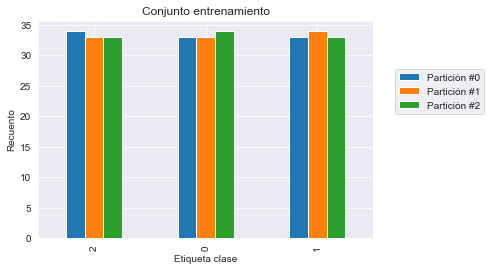

In [1194]:
train_cv_counts.plot.bar()
plt.legend(bbox_to_anchor=(1.05, 0.8), loc="upper left")
plt.ylabel("Recuento")
_ = plt.title("Conjunto entrenamiento")

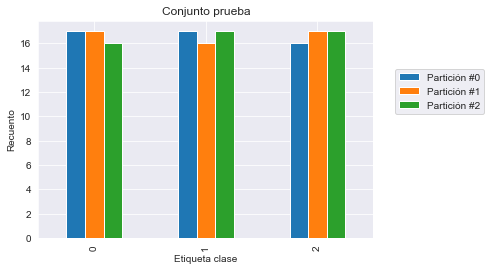

In [1195]:
test_cv_counts.plot.bar()
plt.legend(bbox_to_anchor=(1.05, 0.8), loc="upper left")
plt.ylabel("Recuento")
_ = plt.title("Conjunto prueba")

En este caso, observamos que el recuento de clases es muy parecido entre el conjunto de entrenamiento y el conjunto de prueba. La diferencia es debida al pequeño número de muestras del dataset iris.

En conclusión, es una buena práctica usar estratificación dentro de la validación cruzada cuando se trata de un problema de clasificación.

## Agrupación de muestras

Vamos a detenernos en el concepto de grupos de muestras. Usaremos el dataset de dígitos escritos a mano.

In [1196]:
from sklearn.datasets import load_digits

digits = load_digits()
X, y = digits.data, digits.target

Vamos a recrear el mismo modelo que vimos más arriba: un clasificador de regresión logística con preprocesamiento para escalar los datos.

In [1197]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import make_pipeline

model = make_pipeline(MinMaxScaler(),
                      LogisticRegression(max_iter=1_000))

Usaremos el mismo modelo de línea base. Usaremos una validación cruzada `KFold` sin mezclar los datos al principio.

In [1198]:
from sklearn.model_selection import cross_val_score, KFold

cv = KFold(shuffle=False)
test_score_no_shuffling = cross_val_score(model, X, y, cv=cv, n_jobs=-1)
print(f"La precisión media es: "
      f"{test_score_no_shuffling.mean():.3f} +/- "
      f"{test_score_no_shuffling.std():.3f}")

La precisión media es: 0.931 +/- 0.026


Ahora repitamos lo mismo mezclando los datos dentro de la validación cruzada.

In [1199]:
cv = KFold(shuffle=True)
test_score_with_shuffling = cross_val_score(model, X, y, cv=cv, n_jobs=-1)
print(f"La precisión media es: "
      f"{test_score_with_shuffling.mean():.3f} +/- "
      f"{test_score_with_shuffling.std():.3f}")

La precisión media es: 0.967 +/- 0.008


Observamos que mezclar los datos mejora la precisión media. Podríamos ir un poco más allá y dibujar la distribución de la puntuación de prueba. Primero concatenemos las puntuaciones de prueba.

In [1200]:
import pandas as pd

all_scores = pd.DataFrame(
    [test_score_no_shuffling, test_score_with_shuffling],
    index=["KFold sin mezclado", "KFold con mezclado"],
).T

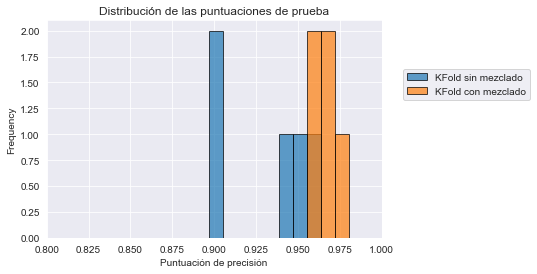

In [1201]:
import matplotlib.pyplot as plt

all_scores.plot.hist(bins=10, edgecolor="black", alpha=0.7)
plt.xlim([0.8, 1.0])
plt.xlabel("Puntuación de precisión")
plt.legend(bbox_to_anchor=(1.05, 0.8), loc="upper left")
_ = plt.title("Distribución de las puntuaciones de prueba")

El error de prueba de validación cruzada que usa el mezclado tiene menos varianza que la que no impone ningún mezclado. Lo que significa que, en este caso, alguna partición específica conduce a una puntuación baja.

In [1202]:
print(test_score_no_shuffling)

[0.94166667 0.89722222 0.94986072 0.9637883  0.90250696]


Por lo tanto, existe una estructura subyacente en los datos que al mezclarlos se rompe y se obtienen mejores resultados. Para tener una mejor comprensión, podríamos leer la documentación que acompaña al dataset.

In [1203]:
print(digits.DESCR)

.. _digits_dataset:

Optical recognition of handwritten digits dataset
--------------------------------------------------

**Data Set Characteristics:**

    :Number of Instances: 1797
    :Number of Attributes: 64
    :Attribute Information: 8x8 image of integer pixels in the range 0..16.
    :Missing Attribute Values: None
    :Creator: E. Alpaydin (alpaydin '@' boun.edu.tr)
    :Date: July; 1998

This is a copy of the test set of the UCI ML hand-written digits datasets
https://archive.ics.uci.edu/ml/datasets/Optical+Recognition+of+Handwritten+Digits

The data set contains images of hand-written digits: 10 classes where
each class refers to a digit.

Preprocessing programs made available by NIST were used to extract
normalized bitmaps of handwritten digits from a preprinted form. From a
total of 43 people, 30 contributed to the training set and different 13
to the test set. 32x32 bitmaps are divided into nonoverlapping blocks of
4x4 and the number of on pixels are counted in each blo

Si leemos cuidadosamente, 13 personas escribieron los dígitos para nuestro dataset, lo que supone un total de 1797 muestras. Por tanto, una persona escribió varias veces el mismo número. Supongamos que las muestras de la persona están agrupadas. En consecuencia, no mezclar los datos mantendrá todas las muestras de la persona juntas, ya sea en el conjunto de entrenamiento como en el de prueba. Mezclar los datos romperá esta estructura y, por tanto, dígitos escritos por la misma persona estarán disponibles tanto en conjunto de entrenamiento como en el de prueba.

Además, por norma general, una persona tenderá a escribir los dígitos de la misma manera. Así, nuestro modelo aprenderá a identificar los patrones de una persona para cada dígito en lugar de reconocer el dígito en sí mismo.

Podemos resolver este problema asegurando que los datos asociados a una persona pertenezcan al conjunto de entrenamiento o al de prueba. Por tanto, queremos agrupar muestras para cada persona. De hecho, podemos recuperar los grupos mirando la variable objetivo.

In [1204]:
y[:200]

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 0, 1,
       2, 3, 4, 5, 6, 7, 8, 9, 0, 9, 5, 5, 6, 5, 0, 9, 8, 9, 8, 4, 1, 7,
       7, 3, 5, 1, 0, 0, 2, 2, 7, 8, 2, 0, 1, 2, 6, 3, 3, 7, 3, 3, 4, 6,
       6, 6, 4, 9, 1, 5, 0, 9, 5, 2, 8, 2, 0, 0, 1, 7, 6, 3, 2, 1, 7, 4,
       6, 3, 1, 3, 9, 1, 7, 6, 8, 4, 3, 1, 4, 0, 5, 3, 6, 9, 6, 1, 7, 5,
       4, 4, 7, 2, 8, 2, 2, 5, 7, 9, 5, 4, 8, 8, 4, 9, 0, 8, 9, 8, 0, 1,
       2, 3, 4, 5, 6, 7, 8, 9, 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 0, 1, 2, 3,
       4, 5, 6, 7, 8, 9, 0, 9, 5, 5, 6, 5, 0, 9, 8, 9, 8, 4, 1, 7, 7, 3,
       5, 1, 0, 0, 2, 2, 7, 8, 2, 0, 1, 2, 6, 3, 3, 7, 3, 3, 4, 6, 6, 6,
       4, 9])

Puede que no sea obvio al principio, pero existe una estructura en el objetivo: existe un patrón repetitivo que siempre empieza por una serie ordenada de dígitos del 0 al 9 seguidos de dígitos aleatorios en un cierto punto. Si miramos en detalle, vemos que existen 14 de tales patrones, siempre con alrededor de 130 muestras cada uno.

Incluso si no corresponden exactamente a las 13 personas que menciona la documentación (quizás una persona escribió dos series de dígitos), podemos hipotetizar que cada uno de esos patrones corresponde a una persona diferente y, por tanto, a un grupo diferente.

In [1205]:
from itertools import count
import numpy as np

# define los límites inferior y superior de cada índice de muestras
# para cada escritor
writer_boundaries = [0, 130, 256, 386, 516, 646, 776, 915, 1029,
                     1157, 1287, 1415, 1545, 1667, 1797]
groups = np.zeros_like(y)
lower_bounds = writer_boundaries[:-1]
upper_bounds = writer_boundaries[1:]

for group_id, lb, up in zip(count(), lower_bounds, upper_bounds):
    groups[lb:up] = group_id

Podemos verificar los grupos dibujando los índices asociados a los id's de escritor.

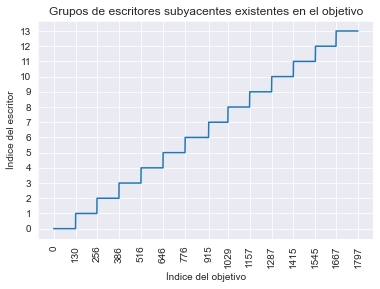

In [1206]:
plt.plot(groups)
plt.yticks(np.unique(groups))
plt.xticks(writer_boundaries, rotation=90)
plt.xlabel("Índice del objetivo")
plt.ylabel("Índice del escritor")
_ = plt.title("Grupos de escritores subyacentes existentes en el objetivo")

Una vez que agrupamos los dígitos por escritor, podemos usar validación cruzada para tener esta información en cuenta: la clase conteniendo `Group` debe ser usada.

In [1207]:
from sklearn.model_selection import GroupKFold

cv = GroupKFold()
test_score = cross_val_score(model, X, y, groups=groups, cv=cv,
                             n_jobs=2)
print(f"La precisión media es "
      f"{test_score.mean():.3f} +/- "
      f"{test_score.std():.3f}")

La precisión media es 0.920 +/- 0.021


Vemos que esta estrategia es menos optimista en lo que respecta al rendimiento de generalización del modelo. Sin embargo, este es más confiable si nuestro propósito es hacer reconocimiento de dígitos manuscritos por escritores independientes. Además, podemos ver que la desviación estándar se ha reducido.

In [1208]:
all_scores = pd.DataFrame(
    [test_score_no_shuffling, test_score_with_shuffling, test_score],
    index=["KFold sin mezclado", "KFold con mezclado",
           "KFold con grupos"],
).T

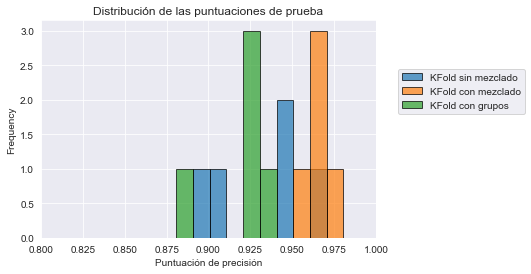

In [1209]:
all_scores.plot.hist(bins=10, edgecolor="black", alpha=0.7)
plt.xlim([0.8, 1.0])
plt.xlabel("Puntuación de precisión")
plt.legend(bbox_to_anchor=(1.05, 0.8), loc="upper left")
_ = plt.title("Distribución de las puntuaciones de prueba")

Como conclusión, cuando evaluamos un modelo es realmente importante tener en cuenta cualquier patrón de agrupamiento de las muestras. De lo contario, los resultados obtenidos podrían ser demasiado optimistas respecto a la realidad.

## Sin datos i.i.d

En machine learning es bastante común asumir que los datos son i.i.d. (acrónimo inglés correspondiente a "*independent and identically distributed*", independientes e idénticamente distribuidos), lo que significa que el proceso generativo no tiene ninguna memoria de muestras pasadas para generar nuevas muestras.

Esta asunción es violada normalmente cuando tratamos con series temporales. Una muestra depende de información pasada.

Veremos un ejemplo para destacar estos problemas con datos no i.i.d en las estrategias de validación cruzada presentadas anteriormente. Vamos a cargar cotizaciones financieras de algunas empresas de energía.

In [1210]:
import pandas as pd

symbols = {"TOT": "Total", "XOM": "Exxon", "CVX": "Chevron",
           "COP": "ConocoPhillips", "VLO": "Valero Energy"}
template_name = "../data/financial-data/{}.csv"

quotes = {}
for symbol in symbols:
    data = pd.read_csv(
        template_name.format(symbol), index_col=0, parse_dates=True
    )
    quotes[symbols[symbol]] = data["open"]
quotes = pd.DataFrame(quotes)

Vamos a empezar dibujando las diferentes cotizaciones financieras.

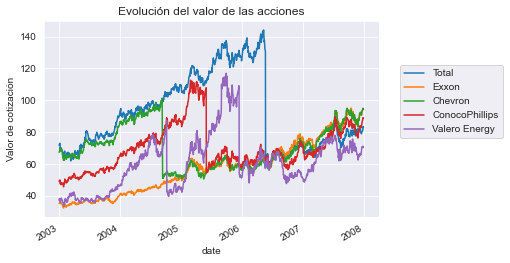

In [1211]:
import matplotlib.pyplot as plt

quotes.plot()
plt.ylabel("Valor de cotización")
plt.legend(bbox_to_anchor=(1.05, 0.8), loc="upper left")
_ = plt.title("Evolución del valor de las acciones")

Vamos a repetir el experimento anterior. En lugar de usar datos aleatorios, esta vez usaremos cotizaciones reales. Aunque es obvio que un modelo predictivo no funciona en la práctica en datos aleatorios, esto es lo mismo con estos datos reales. Aquí queremos predecir la cotización de Chevron usando las cotizaciones de las otras compañías de energía.

Para hacer gráficos explicativos, usaremos una única división además de la validación cruzada que ya usamos anteriormente.

In [1212]:
from sklearn.model_selection import train_test_split

X, y = quotes.drop(columns=["Chevron"]), quotes["Chevron"]
X_train, X_test, y_train, y_test = train_test_split(
    X, y, shuffle=True, random_state=0)

Usaremos un árbol de decisión regresor que esperamos que tenga overfitting y, por tanto, no generalizará a datos no vistos. Usaremos una validación cruzada `ShuffleSplit` para comprobar el rendimiento de generalización de nuestro modelo.

In [1213]:
from sklearn.tree import DecisionTreeRegressor

regressor = DecisionTreeRegressor()

In [1214]:
from sklearn.model_selection import ShuffleSplit

cv = ShuffleSplit(random_state=0)

In [1215]:
from sklearn.model_selection import cross_val_score

test_score = cross_val_score(regressor, X_train, y_train, cv=cv,
                             n_jobs=-1)
print(f"La medida de R2 es: "
      f"{test_score.mean():.2f} +/- {test_score.std():.2f}")

La medida de R2 es: 0.95 +/- 0.07


Sorprendentemente, hemos obtenido un rendimiento de generalización excepcional. Investigaremos y buscaremos la razón de tan buenos resultados con un modelo que se espera que falle. Anteriormente, hemos mencionado que `ShuffleSplit` es un esquema de validación cruzada iterativo que mezcla y divide datos. Simplificaremos este procedimiento con una única división y dibujaremos la predicción. Para este propósito podemos usar `train_test_split`.

In [1216]:
regressor.fit(X_train, y_train)
y_pred = regressor.predict(X_test)
# Afecta el índice de `y_pred` para facilitar el dibujado
y_pred = pd.Series(y_pred, index=y_test.index)

Vamos a comprobar el rendimiento de generalización de nuestro modelo en esta división.

In [1217]:
from sklearn.metrics import r2_score

test_score = r2_score(y_test, y_pred)
print(f"R2 en esta única división es: {test_score:.2f}")

R2 en esta única división es: 0.83


De forma similar, obtenemos buenos resultados en términos de $R^2$. Dibujaremos las muestras de entrenamiento, prueba y predicción.

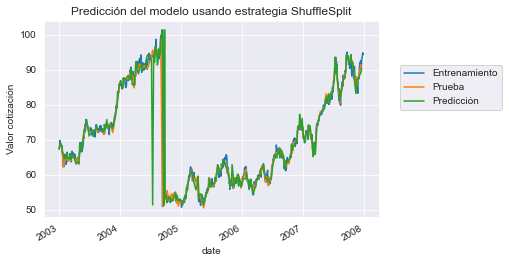

In [1218]:
y_train.plot(label="Entrenamiento")
y_test.plot(label="Prueba")
y_pred.plot(label="Predicción")

plt.ylabel("Valor cotización")
plt.legend(bbox_to_anchor=(1.05, 0.8), loc="upper left")
_ = plt.title("Predicción del modelo usando estrategia ShuffleSplit")

Entonces, en este contexto, parece que las predicciones del modelo siguen las pruebas. Pero también podemos ver que las muestras de prueba están al lado de alguna muestra de entrenamiento. Y con estas series temporales vemos una relación entre una muestra en el momento `t` y una muestra en `t+1`. En este caso estamos violando la asuncion i.i.d. La idea a obtener es la siguiente: un modelo puede generar su conjunto de entrenamiento en el momento `t` para una muestra de prueba en el momento `t+1`. Esta predicción estaría cerca del valor real, incluso aunque nuestro modelo no aprendiera nada, solo memorizando el dataset de entrenamiento.

Una manera sencilla de verificar esta hipótesis es no mezclar los datos cuando hacemos la división. En este caso, usaremos el primer 75% de los datos para entrenar y los datos restantes para prueba.

In [1219]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, shuffle=False, random_state=0,
)
regressor.fit(X_train, y_train)
y_pred = regressor.predict(X_test)
y_pred = pd.Series(y_pred, index=y_test.index)

In [1220]:
test_score = r2_score(y_test, y_pred)
print(f"R2 en esta única división es: {test_score:.2f}")

R2 en esta única división es: -2.16


En este caso vemos que nuestro modelo ya no es mágico. De hecho, su rendimiento es peor que sólo predecir la media del objetivo. Podemos comprobar visualmente qué estamos prediciendo.

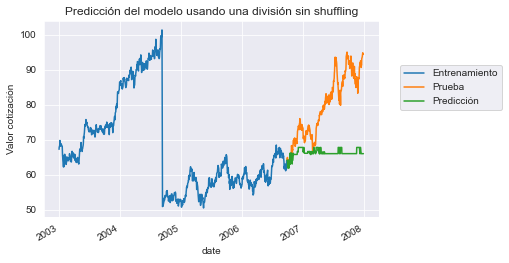

In [1221]:
y_train.plot(label="Entrenamiento")
y_test.plot(label="Prueba")
y_pred.plot(label="Predicción")

plt.ylabel("Valor cotización")
plt.legend(bbox_to_anchor=(1.05, 0.8), loc="upper left")
_ = plt.title("Predicción del modelo usando una división sin shuffling")

Vemos que nuestro modelo no puede predecir nada porque no tiene muestras alrededor de la muestra de prueba. Comprobemos cómo podríamos haber hecho un esquema adecuado de validación cruzada para obtener una estimación razonable del rendimiento de generalización.

Una solución podría ser agrupar los ejemplos en bloques de tiempo, por ejemplo por cuatrimestres, y predecir la información de cada grupo usando información de los otros grupos. Para este propósito, podemos usar la validación cruzada `LeaveOneGroupOut`.

In [1222]:
from sklearn.model_selection import LeaveOneGroupOut

groups = quotes.index.to_period("Q")
cv = LeaveOneGroupOut()
test_score = cross_val_score(regressor, X, y,
                             cv=cv, groups=groups, n_jobs=-1)
print(f"La R2 media es: "
      f"{test_score.mean():.2f} +/- {test_score.std():.2f}")

La R2 media es: -0.74 +/- 1.72


En este caso, vemos que no podemos hacer buenas predicciones, lo que es menos sorprendente que nuestra resultados originales.

Otra cosa a considerar es la aplicación real de nuestra solución. Si nuestro modelo tiene como objetivo la previsión (es decir, predicción de datos futuros a partir de datos pasados), no debemos usar datos de entrenamiento que sean posteriores a los datos de prueba. En este caso, podemos usar la validación `TimeSeriesSplit` para forzar este comportamiento.

In [1223]:
from sklearn.model_selection import TimeSeriesSplit

cv = TimeSeriesSplit(n_splits=groups.nunique())
test_score = cross_val_score(regressor, X, y,
                             cv=cv, groups=groups, n_jobs=2)
print(f"La R2 media es: "
      f"{test_score.mean():.2f} +/- {test_score.std():.2f}")

La R2 media es: -2.27 +/- 3.42


En conclusión, es importante no usar una estrategia de validación cruzada que no respete algunas asunciones, como tener datos i.i.d. Podría conducir a obtener resultados absurdos que podrían hacer pensar que un modelo predictivo podría funcionar.

# Validación cruzada anidada

La validación cruzada se puede usar tanto para el ajuste de hiperparámetros como para la estimación del rendimiento de generalización de un modelo. Sin embargo, usarla para ambos propósitos al mismo tiempo puede ser problemático, ya que la evaluación resultante puede subestimar algún overfitting que resulta del procedimiento de ajuste de hiperparámetros en sí mismo.

Desde un punto de vista filosófico, el ajuste de hiperparámetros es una forma de machine learning en sí misma y, por tanto, necesita otro bucle externo de validación cruzada para evaluar apropiadamente el rendimiento de generalización del procedimiento de modelado global.

Vamos a destacar la validación cruzada anidada y su impacto en el rendimiento de generalización estimado comparado con usar simplemente un único nivel de validación cruzada, tanto para el ajuste de hiperparámetros como para la evaluación del rendimiento de generalización.

Ilustraremos esta diferencia usando el dataset de cáncer de mama.

In [1224]:
from sklearn.datasets import load_breast_cancer

X, y = load_breast_cancer(return_X_y=True)

En primer lugar, usaremos `GridSearchCV` para encontrar los mejores hiperparámetros a través de validación cruzada.

In [1225]:
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC

param_grid = {"C": [0.1, 1, 10], "gamma": [.01, .1]}
model_to_tune = SVC()

search = GridSearchCV(
    estimator=model_to_tune, param_grid=param_grid, n_jobs=-1
)
search.fit(X, y)

GridSearchCV(estimator=SVC(), n_jobs=-1,
             param_grid={'C': [0.1, 1, 10], 'gamma': [0.01, 0.1]})

Recordemos que, internamente, `GridSearchCV` entrena varios modelos para cada conjunto de entrenamiento submuestreado y los evalúa cada uno de ellos en los conjuntos de prueba correspondientes usando validación cruzada. Este procedimiento de evaluación se controla a través del parámetro `cv`. El proceso se repite para todas las posibles combinaciones de parámetros dados en `param_grid`.

El atributo `best_params_` proporciona el mejor conjunto de parámetros que maximizan la puntuación media en los conjuntos de prueba internos.

In [1226]:
print(f"Los mejores parámetros encontrados son: {search.best_params_}")

Los mejores parámetros encontrados son: {'C': 0.1, 'gamma': 0.01}


También podemos mostrar la puntuación media obtenida usando los parámetros `best_params_`.

In [1227]:
print(f"La media de puntuación CV del mejor modelo es: {search.best_score_:.3f}")

La media de puntuación CV del mejor modelo es: 0.627


En esta fase, debemos ser extremadamente cuidadosos al usar esta puntuación. La malinterpretación podría ser la siguiente: dado que esta puntuación media se ha calculado usando conjuntos de prueba de validación cruzada, podemos usarla para evaluar el rendimiento de generalización del modelo entrenado con los mejores hiperparámetros.

Sin embargo, no debemos olvidar que usamos esta puntuación para seleccionar el mejor modelo. Lo que significa que usamos el conocimiento de los conjuntos de prueba (es decir, las puntuaciones de prueba) para seleccionar los hiperparámetros del modelo en sí mismos.

Por lo tanto, esta puntuación media no es una estimación justa de nuestro error de prueba. De hecho, puede ser demasiado optimista, en particular cuando ejecutamos una búsqueda de parámetros de una lista grande con muchos hiperparámetros y muchos posibles valores de los mismos. Una forma de evitar este escollo es usar una validación cruzada anidada.

A continuación, usaremos una validación cruzada interna correspondiente al procedimiento anterior para optimizar únicamente los hiperparámetros. También incluiremos este procedimiento de tunning dentro de una validación cruzada externa, la cual se dedicará a estimar el error de prueba de nuestro modelo tuneado.

En este caso, nuestra validación cruzada interna siempre obtiene el conjunto de entrenamiento de la validación cruzada externa, lo que hace posible calcular siempre las puntuaciones de prueba finales en conjuntos de muestras completamente independientes.

In [1228]:
from sklearn.model_selection import cross_val_score, KFold

# Declara las estrategias de validación cruzada interna y externa
inner_cv = KFold(n_splits=5, shuffle=True, random_state=0)
outer_cv = KFold(n_splits=3, shuffle=True, random_state=0)

# Validación cruzada interna pra la búsqueda de parámetros
model = GridSearchCV(
    estimator=model_to_tune, param_grid=param_grid, cv=inner_cv, n_jobs=-1
)

# Validación cruzada externa para calcular la puntuación de prueba
test_score = cross_val_score(model, X, y, cv=outer_cv, n_jobs=-1)
print(f"La puntuación media usando CV anidada es: "
      f"{test_score.mean():.3f} +/- {test_score.std():.3f}")

La puntuación media usando CV anidada es: 0.627 +/- 0.014


La puntuación reportada es más confiable y deber estar cerca del rendimiento de generalización esperado en producción. Hay que tener en cuenta que, en este caso, las dos puntuaciones son muy parecidas para este primer intento.

Nos gustaría mejorar la evaluación de la diferencia entre las puntuaciones de validación cruzada anidada y no anidada para mostrar que esta última puede ser demasiado optimista en la práctica. Para hacer esto, repetimos el experimento varias veces y mezclamos los datos de forma diferente para asegurar que nuestras conclusiones no dependen de un muestreo particular de los datos.

In [1229]:
test_score_not_nested = []
test_score_nested = []

N_TRIALS = 20
for i in range(N_TRIALS):
    # Para cada intento, usamos divisiones de validación cruzada en
    # datos mezclados aleatoriamente de forma independiente pasando
    # distintos valores al parámetro random_state
    inner_cv = KFold(n_splits=5, shuffle=True, random_state=i)
    outer_cv = KFold(n_splits=3, shuffle=True, random_state=i)

    # Búsqueda de parámetros no anidada y puntuación
    model = GridSearchCV(estimator=model_to_tune, param_grid=param_grid,
                         cv=inner_cv, n_jobs=-1)
    model.fit(X, y)
    test_score_not_nested.append(model.best_score_)

    # Validación cruzada anidada con optimización de parámetros
    test_score = cross_val_score(model, X, y, cv=outer_cv, n_jobs=-1)
    test_score_nested.append(test_score.mean())

Podemos unir los datos juntos y hacer un box plot de las dos estrategias.

In [1230]:
import pandas as pd

all_scores = {
    "Not nested CV": test_score_not_nested,
    "Nested CV": test_score_nested,
}
all_scores = pd.DataFrame(all_scores)

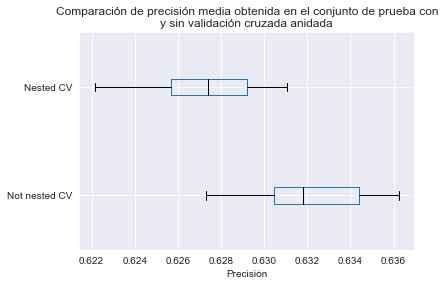

In [1231]:
import matplotlib.pyplot as plt

color = {"whiskers": "black", "medians": "black", "caps": "black"}
all_scores.plot.box(color=color, vert=False)
plt.xlabel("Precisión")
_ = plt.title("Comparación de precisión media obtenida en el conjunto de prueba con\n"
              "y sin validación cruzada anidada")

Observamos que el rendimiento de generalización estimado sin usar CV anidada es mayor que el que obtenemos con CV anidada. La razón es que el procedimiento de tuneado en sí mismo selecciona el modelo con la mayor puntuación de CV interna. Si hay muchas combinaciones de hiperparámetros y si las puntuaciones de CV interna tienen comparativamente grandes desviaciones estándar, tomar el valor máximo puede atraer al científico de datos novato a sobreestimar el verdadero rendimiento de generalización del resultado del procedimiento de aprendizaje completo. Usar un procedimiento de validación cruzada externo proporciona una estimación más confiable del rendimiento de generalización en el procedimiento de aprendizaje completo, incluido el efecto de ajuste de hiperparámetros.

Como conclusión, cuando se optimizan partes de un pipeline de machine learning (por ejemplo, hiperparámetros, transformadores, etc.), se necesita usar validación cruzada anidada para evaluar el rendimiento de generalización del modelo predictivo. De lo contrario, los resultados obtenidos sin validación cruzada anidada suelen ser demasiado optimistas.

# Métricas de clasificación

Los modelos de machine learning se basan en optimizar una función objetivo, buscando su mínimo o máximo. Es importante comprender que esta función objetivo suele estar desacoplada de la métrica de evaluación que queremos optimizar en la práctica. La función objetivo sirve como un proxy de la métrica de evaluación. Por tanto, vamos a presentar las diferentes métricas de evaluación usadas en machine learning.

Ahora vamos a proporcionar una panorámica de las métricas de clasificación que se pueden usar para evaluar el rendimiento de generalización de un modelo predictivo. Recordemos que en un problema de clasificación, el vector `objetivo` es categórico, en lugar de continuo.

Cargaremos el dataset de trasfusiones de sangre.

In [1232]:
import pandas as pd

blood_transfusion = pd.read_csv("../data/blood_transfusion.csv")
X = blood_transfusion.drop(columns="Class")
y = blood_transfusion["Class"]

Comencemos comprobando las clases presentes en el vector objetivo `y`.

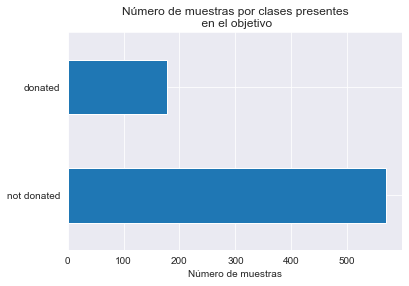

In [1233]:
import matplotlib.pyplot as plt

y.value_counts().plot.barh()
plt.xlabel("Número de muestras")
_ = plt.title("Número de muestras por clases presentes\n en el objetivo")

Podemos ver que el vector `y` contiene dos clases correspondientes a si una persona donó sangre. Usaremos un clasificador de regresión logística para predecir este resultado.

Para centrarnos en la presentación de métricas, solo usaremos una única división en lugar de validación cruzada.

In [1234]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y, shuffle=True, random_state=0, test_size=0.5)

Usaremos una regresión logística como modelo de base. Entrenaremos el modelo en el conjunto de entrenamiento y, después, usaremos el conjunto de prueba para calcular las diferentes métricas de clasificación.

In [1235]:
from sklearn.linear_model import LogisticRegression

classifier = LogisticRegression()
classifier.fit(X_train, y_train)

LogisticRegression()

## Predicciones del clasificador

Antes de entrar en detalles respecto a las métricas, recordemos qué tipo de predicciones puede proporcionar un clasificador.

Por esta razón, crearemos una muestra sintética para un nuevo donante potencial: él/ella donó sangre dos veces en el pasado (1000 cc cada vez). La última vez fue hace 6 meses y la primera hace 20 meses.

In [1236]:
new_donor = pd.DataFrame(
    {
        "Recency": [6],
        "Frequency": [2],
        "Monetary": [1000],
        "Time": [20],
    }
)

Podemos obtener la clase predicha por el clasificador llamando al método `predict`.

In [1237]:
classifier.predict(new_donor)

array(['not donated'], dtype=object)

Con esta información, nuestro clasificador predice que este sujeto sintético es más probable que no done sangre otra vez.

Sin embargo, no podemos comprobar que la predicción es correcta (no sabemos el valor objetivo verdadero). Este es el propósito del conjunto de prueba. Primero, predecimos si un sujeto donará sangre con la ayuda del clasificador entrenado.

In [1238]:
y_pred = classifier.predict(X_test)
y_pred[:5]

array(['not donated', 'not donated', 'not donated', 'not donated',
       'donated'], dtype=object)

## Precisión como línea base

Ahora que tenemos estas predicciones, podemos compararlas con las predicciones reales (también denominadas verdaderas) que no usamos hasta ahora.

In [1239]:
y_test == y_pred

258     True
521    False
14     False
31     False
505     True
       ...  
665     True
100    False
422     True
615     True
743     True
Name: Class, Length: 374, dtype: bool

En la comparación anterior, `True` significa que el valor predicho por nuestra clasificador es idéntico al valor real, mientras que `False` significa que nuestro clasificador ha cometido un error. Una forma de obtener una tasa general que represente el rendimiento de generalización de nuestro clasificador podría ser calcular cuántas veces es correcto nuestro clasificador dividido por el número de muestras de nuestro conjunto.

In [1240]:
import numpy as np

print(f"{np.mean(y_test == y_pred):.3f}")

0.778


Esta medida se denomina precisión (*accuracy*). En este caso, nuestro clasificador tiene un 78% de precisión al clasificar si un sujeto donará sangre. `scikit-learn` provee una función que calcula esta métrica en el módulo `sklearn.metrics`.

In [1241]:
from sklearn.metrics import accuracy_score

accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.3f}")

Accuracy: 0.778


`LogisticRegression` también tiene un método denominado `score` (que es parte de la API estándar de scikit-learn) que calcula la puntuación de accuracy.

In [1242]:
accuracy = classifier.score(X_test, y_test)
print(f"Accuracy: {accuracy:.3f}")

Accuracy: 0.778


## Matriz de confusión y métricas asociadas

La comparación que hicimos anteriormente y la precisión que calculamos no tienen en cuenta el tipo de error que nuestro clasificador está cometiendo. La accuracy es una agregación de los errores cometidos por el clasificador. Es posible que nos interese una granularidad, saber de forma independiente si los errores son por los siguientes casos:

+ predecimos que una persona donará sangre pero no lo hace;
+ predecimos que una persona no donará sangre pero lo hace.

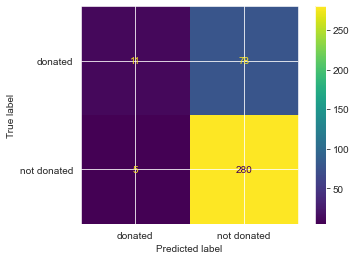

In [1243]:
from sklearn.metrics import ConfusionMatrixDisplay

_ = ConfusionMatrixDisplay.from_estimator(classifier, X_test, y_test)

Los números en diagonal se refieren a las predicciones que fueron correctas, mientras que los números fuera de la diagonal se refieren a las predicciones incorrectas (mal clasisificadas). Ahora conocemos los cuatro tipos de predicciones correctas y erróneas:

+ la esquina superior izquierda son los verdaderos positivos (TP - *true positives*) y corresponden a las personas que donaron sangre y se predijeron como tal por el clasificador;
+ la esquina inferior derecha son los verdaderos negativos (TN - *true negatives*) y corresponden a las personas que no donaron sangre y se predijeron como tal por el clasificador;
+ la esquina superior derecha se corresponde con los falsos negativos (FN - *false negatives*) y corresponden a las personas que donaron sangre pero se predijo que no habían donado sangre;
+ la esquina inferior izquierda son los falsos positivos (FP - *false positives*) y corresponden a las personas que no donaron sangre pero se predijo que sí lo hicieron.

Una vez tenemos dividida esta información, podemos calcular métricas para destacar el rendimiento de generalización de nuestro clasificador en una configuración particular. Por ejemplo, podríamos estar interesados en la fracción de personas que realmente donaron sangre cuando el clasificador lo predijo así o en la fracción de personas que se predijo que habrían donado sangre de la población total que realmente lo hizo.

La métrica anterior, conocida como precisión (*precision*), se define como TP / (TP + FP) y representa la probabilidad de que la persona realmente haya donado sangre cuando el clasificador predijo que lo haría. El último, conocido como sensibilidad (*recall*), se define como TP / (TP + FN) y evalúa cómo de bien el clasificador es capaz de identificar correctamente a las personas que donaron sangre. Al igual que con la accuracy, podríamos calcular estos valores. Sin embargo, scikit-learn proporciona funciones para calcular estos estadísticos.

In [1244]:
from sklearn.metrics import precision_score, recall_score

precision = precision_score(y_test, y_pred, pos_label="donated")
recall = recall_score(y_test, y_pred, pos_label="donated")

print(f"Puntuación precisión: {precision:.3f}")
print(f"Puntuación sensibilidad: {recall:.3f}")

Puntuación precisión: 0.688
Puntuación sensibilidad: 0.124


Estos resultados están en línea con que hemos visto en la matriz de confusión. Mirando en la columna de la izquierda, más de la mitad de las predicciones "donated" fueron correctas, lo que nos lleva a una precisión superior al 0.5. Sin embargo, nuestro clasificador etiquetó erroneamente a muchas personas que donaron sangre como "not donated", lo que nos lleva a una baja sensibilidad de aproximadamente 0.1.

## El problema del desequilibrio de clases

En esta fase, podríamos plantearnos una pregunta razonable. Si bien la accuracy no parecía mala (es decir, 77%), la sensibilidad es relativamente baja (es decir, 12%). Como mencionábamos, la precisión y la sensibilidad solo se centran en muestras predichas como positivas. Además, no observamos la proporción de clases. Podríamos comprobar esta proporción en el conjunto de entrenamiento.

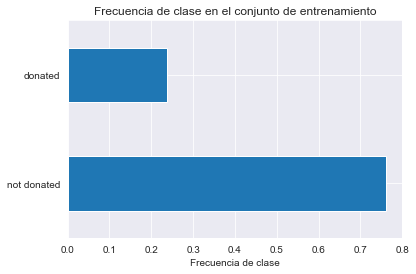

In [1245]:
y_train.value_counts(normalize=True).plot.barh()
plt.xlabel("Frecuencia de clase")
_ = plt.title("Frecuencia de clase en el conjunto de entrenamiento")

Observamos que la clase positiva, `donated`, comprende únicamente el 24% de las muestras. La buena accuracy de nuestro clasificador esta ligada entonces a su habilidad de predecir correctamente la clase negativa `not donated`, que puede o no ser relevante, dependiendo de la aplicación. Podemos ilustrar este problema usando un clasificado dummy como línea base.

In [1246]:
from sklearn.dummy import DummyClassifier

dummy_classifier = DummyClassifier(strategy="most_frequent")
dummy_classifier.fit(X_train, y_train)
print(f"Accuracy del clasificador dummy: "
      f"{dummy_classifier.score(X_test, y_test):.3f}")

Accuracy del clasificador dummy: 0.762


Con el clasificador dummy, que siempre predice la clase más frecuente, en nuestro caso la clase `not donated`, obtenemos un accuracy del 76%. Por tanto, significa que este clasificador, sin aprender nada de los datos `X`, es capaz de predecir más precisamente que nuestro modelo de regresión logística.

Este problema es también conocido como el problema de desequilibrio de clases. Cuando las clases están desbalanceadas, no se debe usar accuracy. En este caso, debemos usar la precisión y la sensibilidad como presentamos anteriormente o la puntuación accuracy equilibrada en lugar de la accuracy.

In [1247]:
from sklearn.metrics import balanced_accuracy_score

balanced_accuracy = balanced_accuracy_score(y_test, y_pred)
print(f"Accuracy balanceada: {balanced_accuracy:.3f}")

Accuracy balanceada: 0.553


La accuracy balanceada es equivalente a la accuracy en un contexto de clases equilibradas. Se define como la sensibilidad media obtenida en cada clase.

# Evaluación y diferentes umbrales de probabilidad

Todas las estadísticas que hemos presentado hasta ahora se basan en `classifier.predict` que devuelve la etiqueta más probable. No hemos hecho uso de la probabilidad asociada con esta predicción, la cual proporciona la confianza del clasificador en esta predicción. Por defecto, la predicción de un clasificador corresponde a un umbral de 0.5 de probabilidad en un problema de clasificación binaria. Podemos comprobar rápidamente esta relación con el clasificador que entrenamos.

In [1248]:
target_proba_predicted = pd.DataFrame(classifier.predict_proba(X_test),
                                      columns=classifier.classes_)
target_proba_predicted[:5]

,donated,not donated
0,0.271820,0.728180
1,0.451764,0.548236
2,0.445211,0.554789
3,0.441577,0.558423
4,0.870583,0.129417


In [1249]:
y_pred = classifier.predict(X_test)
y_pred[:5]

array(['not donated', 'not donated', 'not donated', 'not donated',
       'donated'], dtype=object)

Dado que las probabilidades suman 1, podemos obtener la clase con la mayor probabilidad sin usar el umbral de 0.5.

In [1250]:
equivalence_pred_proba = (
    target_proba_predicted.idxmax(axis=1).to_numpy() == y_pred)
np.all(equivalence_pred_proba)

True

El umbral de decisión predeterminado (0.5) puede no ser el mejor umbral que conduce al rendimiento de generalización óptimo de nuestro clasificador. En este caso, podemos variar el umbral de decisión y, por lo tanto, la predicción subsiguiente y calcular las mismas estadísticas presentadas anteriormente. Normalmente, las dos métricas, sensibilidad y precisión, son calculadas y dibujadas en un gráfico. Cada métrica dibujada en un eje del gráfico y cada punto del gráfico corresponde a un umbral de decisión específico. Empecemos calculando la curva *precision-recall*.

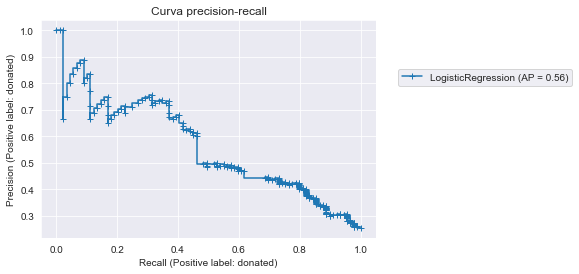

In [1251]:
from sklearn.metrics import PrecisionRecallDisplay

disp = PrecisionRecallDisplay.from_estimator(
    classifier, X_test, y_test, pos_label='donated',
    marker="+"
)
plt.legend(bbox_to_anchor=(1.05, 0.8), loc="upper left")
_ = disp.ax_.set_title("Curva precision-recall")

En esta curva, cada cruz azul corresponde a un nivel de probabilidad que usamos como umbral de decisión. Podemos ver que variando este umbral de decisión obtenemos diferentes valores de precisión vs sensibilidad.

Un clasificador perfecto tendría una precisión de 1 para todos los valores de sensibilidad. Una métrica que caracteriza la curva está referida al área bajo la curva (AUC - *area under the curve*) y se denomina precisión media (AP). Con un clasificador ideal, la precisión media sería 1.

Las métricas de precisión y sensibilidad se centran en la clase positiva, sin embargo, podríamos estar interesados en el compromiso entre discriminar con precisión la clase positiva y discriminar con precisión las clases negativas. Las estadísticas usadas para esto son la sensibilidad y la especificidad. La especificidad mide la proporción de muestras clasificadas correctamente en la clase negativa y se define como: TN / (TN + FP). De forma similar a la curva precisión-sensibilidad, la sensibilidad y la especificidad se dibujan generalmente con una curva denominada ROC (*receiver operating characteristic*). Esta sería la curva ROC:

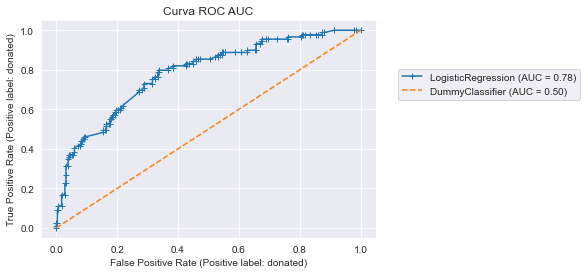

In [1252]:
from sklearn.metrics import RocCurveDisplay

disp = RocCurveDisplay.from_estimator(
    classifier, X_test, y_test, pos_label='donated',
    marker="+")
disp = RocCurveDisplay.from_estimator(
    dummy_classifier, X_test, y_test, pos_label='donated',
    color="tab:orange", linestyle="--", ax=disp.ax_)
plt.legend(bbox_to_anchor=(1.05, 0.8), loc="upper left")
_ = disp.ax_.set_title("Curva ROC AUC")

Esta curva se construyó usando el mismo principio que la curva precisión-sensibilidad: variamos el umbral de probabilidad para determinar la predicción "dura" y calculamos las métricas. Al igual que la curva precisión-sensibilidad, podemos calcular el área bajo la ROC (ROC-AUC) para caracterizar el rendimiento de generalización de nuestro clasificador. Sin embargo, es importante observar que el límite inferior de ROC-AUC es 0.5. De hecho, mostramos el rendimiento de generalización de un clasificador dummy (la linea discontinua naranja) para mostrar que incluso el peor rendimiento de generalización obtenido estará por encima de esta línea.

## Ejercicio métricas de clasificación

Anteriormente hemos presentado diferentes métricas de clasificación pero no las usamos con validación cruzada. En este ejercicio practicaremos e implementaremos validación cruzada.

Volveremos a usar el dataset de transfusiones de sangre.

In [1253]:
import pandas as pd

blood_transfusion = pd.read_csv("../data/blood_transfusion.csv")
X = blood_transfusion.drop(columns="Class")
y = blood_transfusion["Class"]

En primer lugar, vamos a crear un árbol de decisión clasificador.

In [1254]:
from sklearn.tree import DecisionTreeClassifier

tree = DecisionTreeClassifier()

Vamos a crear un objeto de validación cruzada `StratifiedKFold`. Después lo usaremos dentro de la función `cross_val_score` para evaluar el árbol de decisión. Primero usaremos la accuracy para evaluar el árbol de decisión. Usaremos explícitamente el parámetro `scoring` de `cross_val_score` para calcula la accuracy (aunque sea ésta la puntuación por defecto). Compruebe su documentación para aprender cómo hacerlo.

In [1255]:
from sklearn.model_selection import StratifiedKFold, cross_val_score

cv = StratifiedKFold(n_splits=10)

scores = cross_val_score(tree, X, y, scoring="accuracy",
                          cv=cv, n_jobs=-1)
print(f"Puntuación accuracy: "
      f"{scores.mean():.3f} +/- {scores.std():.3f}")

Puntuación accuracy: 0.631 +/- 0.141


Repetiremos el experimento calculando la `balanced_accuracy`.

In [1256]:
scores_balanced_accuracy = cross_val_score(tree, X, y, scoring="balanced_accuracy",
                          cv=cv, n_jobs=-1)
print(f"Puntuación accuracy balanceada: "
      f"{scores_balanced_accuracy.mean():.3f} +/- {scores_balanced_accuracy.std():.3f}")

Puntuación accuracy balanceada: 0.503 +/- 0.114


Ahora añadiremos un poco de complejidad. Queremos calcular la precisión de nuestro modelo. Sin embargo, anteriormente vimos que necesitamos mencionar la etiqueta positiva, que en nuestro caso consideramos que es la clase `donated`.

Mostraremos que calcular la precisión sin suministrar la clase positiva no es soportado por scikit-learn porque, de hecho, es ambigüo.

In [1257]:
try:
    scores = cross_val_score(tree, X, y, cv=10, scoring="precision")
except ValueError as exc:
    print(exc)

C:\Program Files\Python310\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python310\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Program Files\Python310\lib\site-packages\sklearn\metrics\_scorer.py", line 103, in __call__
    score = scorer._score(cached_call, estimator, *args, **kwargs)
  File "C:\Program Files\Python310\lib\site-packages\sklearn\metrics\_scorer.py", line 264, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "C:\Program Files\Python310\lib\site-packages\sklearn\metrics\_classification.py", line 1757, in precision_score
    p, _, _, _ = precision_recall_fscore_support(
  File "C:\Program Files\Python310\lib\site-packages\sklearn\metrics\_classifica

Obtenemos una excepción, porque el scorer por defecto tiene su etiqueta positiva marcada como uno (`pos_label=1`), que no es nuestro caso (nuestra etiqueta positiva es `donated`). En este caso, necesitamos crear un scorer usando la función scoring y la función helper `make_scorer`.

Por tanto, importamos `sklearn.metrics.make_scorer` y `sklearn.metrics.precision_score`. Consulta la documentación para más información. Finalmente, creamos un scorer llamando a `make_scorer` usando la función de puntuación `precision_score` y pasándole el parámetro extra `pos_label="donated"`.

In [1258]:
from sklearn.metrics import  make_scorer, precision_score

precision = make_scorer(precision_score, pos_label="donated")

Ahora, en lugar de suministrar la cadena `"precision"` al parámetro `scoring` en la llamada `cross_val_score`, le pasamos el scorer que acabamos de crear.

In [1259]:
scores_precision = cross_val_score(tree, X, y, cv=10, scoring=precision)
print(f"Puntuación precisión: "
      f"{scores_precision.mean():.3f} +/- {scores_precision.std():.3f}")

Puntuación precisión: 0.246 +/- 0.170


`cross_val_score` solo calculará un única puntuación proporcionada al parámetro `scoring`. La función `cross_validate` permite el cálculo de múltiples puntuaciones pasándole una lista de cadenas o scorer al parámetro `scoring`, lo que podría ser útil.

Importaremos `sklearn.model_selection.cross_validate` y calcularemos la accuracy y la accuracy balanceada a través de validación cruzada. Dibujaremos la puntuación de validación cruzada para ambas métricas usando un box plot.

In [1260]:
from sklearn.model_selection import cross_validate

scores = cross_validate(tree, X, y, scoring=["accuracy", "balanced_accuracy"],
                         cv=cv, n_jobs=-1)

In [1261]:
scores

{'fit_time': array([0.00250149, 0.00250244, 0.00300288, 0.00250196, 0.00250196,
        0.00250149, 0.00350356, 0.00350428, 0.0035038 , 0.00400329]),
 'score_time': array([0.00200152, 0.00250149, 0.00450349, 0.00200224, 0.00250244,
        0.00250363, 0.00300264, 0.00200105, 0.00250173, 0.002002  ]),
 'test_accuracy': array([0.29333333, 0.53333333, 0.77333333, 0.56      , 0.58666667,
        0.68      , 0.68      , 0.78666667, 0.64864865, 0.74324324]),
 'test_balanced_accuracy': array([0.42105263, 0.48391813, 0.66081871, 0.40643275, 0.42397661,
        0.44736842, 0.54239766, 0.74561404, 0.4623323 , 0.50309598])}

In [1262]:
print(f"Puntuación accuracy: "
      f"{scores['test_accuracy'].mean():.3f} +/- {scores['test_accuracy'].std():.3f}")

Puntuación accuracy: 0.629 +/- 0.139


In [1263]:
print(f"Puntuación accuracy balanceada: "
      f"{scores['test_balanced_accuracy'].mean():.3f} +/- {scores['test_balanced_accuracy'].std():.3f}")

Puntuación accuracy balanceada: 0.510 +/- 0.106


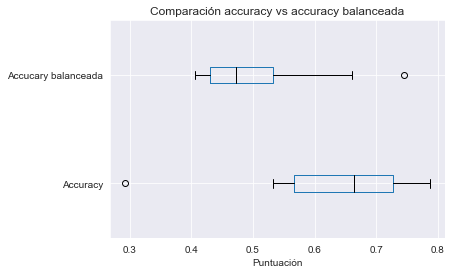

In [1264]:
all_scores = {
    "Accuracy": scores['test_accuracy'],
    "Accucary balanceada": scores['test_balanced_accuracy'],
}
all_scores = pd.DataFrame(all_scores)

color = {"whiskers": "black", "medians": "black", "caps": "black"}
all_scores.plot.box(color=color, vert=False)
plt.xlabel("Puntuación")
_ = plt.title("Comparación accuracy vs accuracy balanceada")

# Métricas de regresión

Vamos a presentar las métricas que pueden usarse en regresión. Existen un conjunto de métricas dedicadas a la regresión. De hecho, las métricas de clasificación no pueden usarse para evaluar el rendimiento de generalización de modelos de regresión porque hay una diferencia fundamental entre sus tipos de objetivos: es una variable continua en el caso de la regresión, mientras que en el caso de la clasificación es una variable discreta.

Usaremos el dataset de viviendas de Ames. El objetivo es predecir el precio de las propiedades en la ciudad de Ames, Iowa. Al igual que con la clasificación, solo usaremos una única división entrenamiento-prueba para enfocarnos únicamente en las métricas de regresión.

In [1265]:
import pandas as pd
import numpy as np

ames_housing = pd.read_csv("../data/house_prices.csv")
X = ames_housing.drop(columns="SalePrice")
y = ames_housing["SalePrice"]
X = X.select_dtypes(np.number)
y /= 1000

In [1266]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y, shuffle=True, random_state=0
)

Algunos modelos de machine learning están diseñados para resolverse como un problema de optimización: minimizan un error (también conocida como función de pérdida) usando un conjunto de entrenamiento. Una función de pérdida básica que se usa en regresión es el error cuadrático medio (MSE). Por lo tanto, esta métrica se usa a veces para evaluar el modelo dado que ya está optimizada por este modelo.

Veamos un ejemplo usando un modelo de regresión lineal.

In [1267]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

regressor = LinearRegression()
regressor.fit(X_train, y_train)
y_pred = regressor.predict(X_train)

print(f"MSE en el conjunto de entrenamiento: "
      f"{mean_squared_error(y_train, y_pred):.3f}")

MSE en el conjunto de entrenamiento: 996.902


Nuestro modelo de regresión lineal está minimizando el error cuadrático medio en el conjunto de entrenamiento. Significa que no existe otro conjunto de coeficientes que reduzcan más el error.

Vamos a calcular el MSE en el conjunto de prueba.

In [1268]:
y_pred = regressor.predict(X_test)

print(f"MSE en el conjunto de prueba: "
      f"{mean_squared_error(y_test, y_pred):.3f}")

MSE en el conjunto de prueba: 2064.736


El MSE en bruto puede ser difícil de interpretar. Una forma es reescalar el MSE por la varianza del objetivo. Esta puntuación se conoce como $R^2$, también conocida como coeficiente de determinación. De hecho, esta es la puntuación por defecto que usa scikit-learn cuando se llama al método `score`.

In [1269]:
regressor.score(X_test, y_test)
print(f"R2 en el conjunto de prueba: "
      f"{regressor.score(X_test, y_test):.3f}")

R2 en el conjunto de prueba: 0.687


La puntuación $R^2$ representa la proporción de varianza del objetivo que es explicada por las variables independientes del modelo. La mejor puntuación posible es 1 pero no existe límite inferior. Sin embargo, un modelo que predice el valor esperado del objetivo obtendría una puntación de 0.

In [1270]:
from sklearn.dummy import DummyRegressor

dummy_regressor = DummyRegressor(strategy="mean")
dummy_regressor.fit(X_train, y_train)
print(f"R2 para un regresor que predice la media:"
      f"{dummy_regressor.score(X_test, y_test):.3f}")

R2 para un regresor que predice la media:-0.000


La puntuación $R^2$ nos da ideas de la calidad del ajuste del modelo. Sin embargo, esta puntuación no se puede comparar de un dataset a otro y el valor obtenido no tiene una interpretación significativa en relación a la unidad original del objetivo. Si buscamos obtener una puntuación interpretable, nos interesaría la mediana o el error absoluto medio.

In [1271]:
from sklearn.metrics import mean_absolute_error

y_pred = regressor.predict(X_test)
print(f"MAE: "
      f"{mean_absolute_error(y_test, y_pred):.3f} k$")

MAE: 22.608 k$


Al calcular el error absoluto medio, podemos interpretar que nuestro modelo está prediciendo en promedio con un márgen de 22.6 k$ respecto al valor verdadero de la propiedad. Una desventaja de esta métrica es que la media se puede ver impactada por errores grandes. Para algunas aplicaciones, es posible que no queramos que estos grandes errores tengan una gran influencia en nuestra métrica. En este caso, podemos usar el error absoluto mediano.

In [1272]:
from sklearn.metrics import median_absolute_error

print(f"Error absoluto mediano: "
      f"{median_absolute_error(y_test, y_pred):.3f} k$")

Error absoluto mediano: 14.137 k$


El error absoluto medio (o el error absoluto mediano) aún sigue teniendo una limitación conocida: cometer un error de 50 k dólares en una casa valorada en 50 k dólares tiene el mismo impacto que cometerlo en una casa de 500 k dólares. De hecho, el error absoluto medio no es relativo.

El error porcentual absoluto medio introduce este escalado relativo.

In [1273]:
from sklearn.metrics import mean_absolute_percentage_error

print(f"Error porcentual absoluto medio: "
      f"{mean_absolute_percentage_error(y_test, y_pred) * 100:.3f} %")

Error porcentual absoluto medio: 13.574 %


Además de métricas, podemos representar visualmente los resultados dibujando los valores predichos vs los valores reales.

In [1274]:
predicted_actual = {
    "Valores reales (k$)": y_test, "Valores predichos (k$)": y_pred}
predicted_actual = pd.DataFrame(predicted_actual)

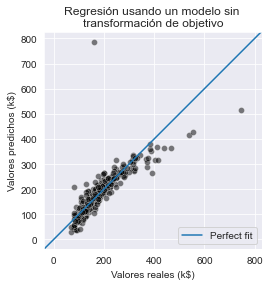

In [1275]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.scatterplot(data=predicted_actual,
                x="Valores reales (k$)", y="Valores predichos (k$)",
                color="black", alpha=0.5)
plt.axline((0, 0), slope=1, label="Perfect fit")
plt.axis('square')
plt.legend()
_ = plt.title("Regresión usando un modelo sin \ntransformación de objetivo")

En este gráfico, las predicciones correctas estarían en la línea diagonal. Este gráfico permite detectar si el modelo comete errores de forma consistente, es decir, si tiene algún sesgo (bias).

En este gráfico vemos que para los valores reales altos, nuestro modelo tiende a subestimar el precio de la propiedad. Normalmente, este problema surge cuando el objetivo a predecir no sigue una distribución normal. En este caso, el modelo se podría beneficiar de la trasformación de objetivo.

In [1276]:
from sklearn.preprocessing import QuantileTransformer
from sklearn.compose import TransformedTargetRegressor

transformer = QuantileTransformer(
    n_quantiles=900, output_distribution="normal")
model_transformed_target = TransformedTargetRegressor(
    regressor=regressor, transformer=transformer)
model_transformed_target.fit(X_train, y_train)
y_pred = model_transformed_target.predict(X_test)

In [1277]:
predicted_actual = {
    "Valores reales (k$)": y_test, "Valores predichos (k$)": y_pred}
predicted_actual = pd.DataFrame(predicted_actual)

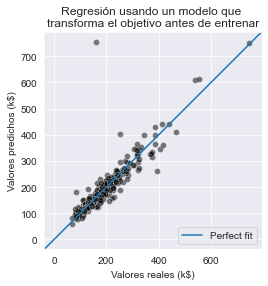

In [1278]:
sns.scatterplot(data=predicted_actual,
                x="Valores reales (k$)", y="Valores predichos (k$)",
                color="black", alpha=0.5)
plt.axline((0, 0), slope=1, label="Perfect fit")
plt.axis('square')
plt.legend()
_ = plt.title("Regresión usando un modelo que \ntransforma el objetivo antes de entrenar")

Así, vemos que una vez trasformado el objetivo, vemos que corregimos algunos de los valores altos.

## Ejercicio de métricas de regresión

Vamos a evaluar las métricas de regresión dentro de una validación cruzada para familiarizarnos con la sintaxis. Usaremos el dataset de viviendas de Ames.

In [1279]:
ames_housing = pd.read_csv("../data/house_prices.csv")
X = ames_housing.drop(columns="SalePrice")
y = ames_housing["SalePrice"]
X = X.select_dtypes(np.number)
y /= 1000

El primer paso es crear un modelo de regresión lineal.

In [1280]:
from sklearn.linear_model import LinearRegression

model = LinearRegression()

Después, usaremos `cross_val_score` para estimar el rendimiento de generalización del modelo. Usaremos una validación cruzada `KFold` con 10 particiones. Haremos uso de la puntuación $R^2$ asignando explícitamente el parámetro `scoring` (a pesar de que es la puntuación por defecto).

In [1281]:
from sklearn.model_selection import cross_val_score, KFold

cv = KFold(n_splits=10)

scores = cross_val_score(model, X, y, scoring="r2",
                         cv=cv, n_jobs=-1)
print(f"R2: {scores.mean():.3f} +/- {scores.std():.3f}")

R2: 0.794 +/- 0.103


Ahora, en lugar de usar la puntuación $R^2$, usaremos el error absoluto medio.

In [1282]:
scores = cross_val_score(model, X, y, scoring="neg_mean_absolute_error",
                         cv=cv, n_jobs=-1)
print(f"MAE: {-scores.mean():.3f} +/- {-scores.std():.3f}")

MAE: 21.892 +/- -2.225


En scikit-learn, el parámetro `scoring` espera puntuaciones. Esto significa que cuanto mayor sean los valores y menores sean los errores, mejor será el modelo. Por lo tanto, el error debe multiplicarse por -1. Esta es la causa del prefijo `neg_` de la cadena del scoring cuando tratamos con métricas que son errores.

Por último, usaremos la función `cross_validate` y calcularemos múltiples puntuaciones/errores a la vez pasándole una lista de marcadores al parámetros `scoring`. Calcularemos la puntuación $R^2$ y el error absoluto medio.

In [1283]:
from sklearn.model_selection import cross_validate

scores = cross_validate(model, X, y,
                        scoring=["r2", "neg_mean_absolute_error"],
                        cv=cv, n_jobs=-1)
print(f"R2: {scores['test_r2'].mean():.3f} +/- {scores['test_r2'].std():.3f}")
print(f"MAE: {-scores['test_neg_mean_absolute_error'].mean():.3f} +/- "
      f"{-scores['test_neg_mean_absolute_error'].std():.3f}")

R2: 0.794 +/- 0.103
MAE: 21.892 +/- -2.225


In [1284]:
scores

{'fit_time': array([0.00350285, 0.00300288, 0.00350332, 0.00350285, 0.00350308,
        0.00350261, 0.00400424, 0.00350285, 0.00300217, 0.00300312]),
 'score_time': array([0.00200248, 0.0025022 , 0.00200105, 0.00250173, 0.00200129,
        0.00200224, 0.00200129, 0.00200176, 0.00150156, 0.00150156]),
 'test_r2': array([0.84390289, 0.85497435, 0.88752303, 0.74951104, 0.81698014,
        0.82013355, 0.81554085, 0.81452472, 0.50115778, 0.83330693]),
 'test_neg_mean_absolute_error': array([-20.48049905, -21.38003105, -21.26831487, -22.86887664,
        -24.79955736, -18.95827641, -20.11793792, -20.5040172 ,
        -26.76774564, -21.77871056])}

# Ejercicio

Vamos a poner en práctica lo aprendido en este post con un ejercicio. Para ello usaremos el dataset de bicis.

In [1285]:
import pandas as pd

cycling = pd.read_csv("../data/bike_rides.csv", index_col=0,
                      parse_dates=True)
cycling.index.name = ""
target_name = "power"
X, y = cycling.drop(columns=target_name), cycling[target_name]
X.head()

,heart-rate,cadence,speed,acceleration,slope
,,,,,
2020-08-18 14:43:19,102.0,64.0,4.325,0.0880,-0.033870
2020-08-18 14:43:20,103.0,64.0,4.336,0.0842,-0.033571
2020-08-18 14:43:21,105.0,66.0,4.409,0.0234,-0.033223
2020-08-18 14:43:22,106.0,66.0,4.445,0.0016,-0.032908
2020-08-18 14:43:23,106.0,67.0,4.441,0.1144,0.000000


En este dataset, el problema es intentar predecir la potencia de un ciclista usando sensores baratos (GPS, monitores de frecuencia cardíaca, etc.). De hecho, la potencia se puede registrar a través de medidores ciclistas de potencia, pero dichos dispositivos suelen ser bastante caros.

En lugar de usar machine learning a ciegas, primero presentaremos un poco de mecánica clásica: la segunda ley de Newton.

$P_{meca} = (\frac{1}{2} \rho . SC_x . V_{a}^{2} + C_r . mg . \cos \alpha + mg . \sin \alpha + ma) V_d$

donde $\rho$ es la densidad del aire en kg.m$^{-3}$, $S$ es la superficie frontal del ciclista en m$^{2}$, $C_x$ es el coeficiente de resistencia, $V_a$ es la velocidad del aire en m.s$^{-1}$, $C_r$ es la resistencia a la rodadura, $m$ es la masa del ciclista y la bicicleta en kg, $g$ es la aceleración estándar debida a la gravedad, que es igual a  9.81 m.s$^{-2}$, $\alpha$ es la pendiente en radianes, $V_d$ es la velocidad del ciclista m.s$^{-1}$, y $a$ es la aceleración del ciclista en m.s$^{-2}$.

Al principio, esta ecuación podría parecer un poco compleja pero podemos explicar con palabras lo que significan los diferéntes términos dentro del paréntesis:

+ el primer término es la potencia que se requiere que produzca un ciclista para luchar contra el viento
+ el segundo término es la potencia que se requiere que produzca un ciclista para luchar contrar la resistencia a la rodadura creada por los neumáticos en la pista
+ el tercer término es la potencia que se requiere que produzca un ciclista para subir una colina si la pendiente es positiva. Si la pendiente es negativa, el ciclista no necesita producir ninguna potencia para avanzar
+ el cuarto y último término es la potencia que se requiere que produzca un ciclista para cambiar su velocidad (es decir, aceleración).


Podemos simplificar el modelo anterior usando los datos que tenemos a mano. Se vería como lo siguiente:

$P_{meca} = \beta_{1} V_{d}^{3} + \beta_{2} V_{d} + \beta_{3} \sin(\alpha) V_{d} + \beta_{4} a V_{d}$



Este modelo está más cerca de lo que vimos anteriormente: es un modelo lineal entrenado en una transformación de features no lineal. Construiremos, entrenaremos y evaluaremos un modelo de este tipo como parte del ejercicio. Por tanto, necesitaremos:

+ crear una nueva matriz de datos conteniendo el cubo de la velocidad, la velocidad, la velocidad multiplicada por el seno del ángulo de la pendiente y la velocidad multiplicada por la aceleración. Para calcular el ángulo de la pendiente, necesitamos tomar el arcotangente de la pendiente (`alpha = np.arctan(slope)`). Además, podemos limitarnos a la aceleración positiva solo recortando a 0 los valores de aceleración negativa (correspondería a alguna potencia creada por el frenado que no estamos modelando aquí).
+ usando la nueva matriz de datos, crear un modelo predictivo lineal basado en un [`sklearn.preprocessing.StandardScaler`](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html) y [`sklearn.linear_model.RidgeCV`](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.RidgeCV.html).
+ usar un estrategia de validación cruzada [`sklearn.model_selection.ShuffleSplit`](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.ShuffleSplit.html) con solo 4 particiones (`n_splits=4`) para evaluar el rendimiento de generalización del modelo. Usaremos el error absoluto medio (MAE) como métrica del rendimiento de generalización. Además, pasaremos el parámetro `return_estimator=True` y `return_train_score=True`. Tengamos en cuenta que la estrategia `ShuffleSplit` es un estrategia ingenua y simple e investigaremos las consecuencias de esta elección más adelante.

In [1286]:
X["speed_3"] = X["speed"] ** 3
X["speed_x_sin_slope"] = X["speed"] * np.sin(np.arctan(X["slope"]))
X["speed_x_accel"] = X["speed"] * X["acceleration"].clip(lower=0)
X.head()

,heart-rate,cadence,speed,acceleration,slope,speed_3,speed_x_sin_slope,speed_x_accel
,,,,,,,,
2020-08-18 14:43:19,102.0,64.0,4.325,0.0880,-0.033870,80.901828,-0.146402,0.380600
2020-08-18 14:43:20,103.0,64.0,4.336,0.0842,-0.033571,81.520685,-0.145482,0.365091
2020-08-18 14:43:21,105.0,66.0,4.409,0.0234,-0.033223,85.707790,-0.146398,0.103171
2020-08-18 14:43:22,106.0,66.0,4.445,0.0016,-0.032908,87.824421,-0.146198,0.007112
2020-08-18 14:43:23,106.0,67.0,4.441,0.1144,0.000000,87.587538,0.000000,0.508050


In [1287]:
print(f"{X['speed_x_sin_slope'].mean():.3f}")

-0.003


In [1288]:
features = ["speed_3", "speed", "speed_x_sin_slope", "speed_x_accel"]
X_linear_model = X[features].copy()
X_linear_model.head()

,speed_3,speed,speed_x_sin_slope,speed_x_accel
,,,,
2020-08-18 14:43:19,80.901828,4.325,-0.146402,0.380600
2020-08-18 14:43:20,81.520685,4.336,-0.145482,0.365091
2020-08-18 14:43:21,85.707790,4.409,-0.146398,0.103171
2020-08-18 14:43:22,87.824421,4.445,-0.146198,0.007112
2020-08-18 14:43:23,87.587538,4.441,0.000000,0.508050


In [1289]:
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import ShuffleSplit, cross_validate
from sklearn.linear_model import RidgeCV

model = make_pipeline(StandardScaler(), RidgeCV())
cv = ShuffleSplit(n_splits=4, random_state=0)
cv_scores = cross_validate(model, X_linear_model, y, scoring="neg_mean_absolute_error",
                           return_estimator=True, return_train_score=True,
                           cv=cv, n_jobs=-1)
cv_scores

{'fit_time': array([0.02552152, 0.02652311, 0.02452087, 0.02452159]),
 'score_time': array([0.00150347, 0.002002  , 0.00200343, 0.00150061]),
 'estimator': [Pipeline(steps=[('standardscaler', StandardScaler()),
                  ('ridgecv', RidgeCV(alphas=array([ 0.1,  1. , 10. ])))]),
  Pipeline(steps=[('standardscaler', StandardScaler()),
                  ('ridgecv', RidgeCV(alphas=array([ 0.1,  1. , 10. ])))]),
  Pipeline(steps=[('standardscaler', StandardScaler()),
                  ('ridgecv', RidgeCV(alphas=array([ 0.1,  1. , 10. ])))]),
  Pipeline(steps=[('standardscaler', StandardScaler()),
                  ('ridgecv', RidgeCV(alphas=array([ 0.1,  1. , 10. ])))])],
 'test_score': array([-73.23006461, -72.1311734 , -72.89061823, -71.2370263 ]),
 'train_score': array([-72.35634493, -72.51703894, -72.42974777, -72.6121094 ])}

**¿De media, cuál es el error absoluto medio en el conjunto de prueba obtenido en la validación cruzada?**

In [1290]:
print(f"MAE es: {-cv_scores['test_score'].mean():.2f} +/- "
      f"{cv_scores['test_score'].std():.2f}")

MAE es: 72.37 +/- 0.77


**Muestra los coeficientes del modelo lineal resultado de la validación cruzada**

In [1291]:
for estimator in cv_scores["estimator"]:
   print(estimator[-1].coef_)

[ 5.66427806 32.84904152 80.08105928 10.85618779]
[ 5.68897463 32.83434375 80.99005594 11.34425   ]
[ 6.28736152 32.19112942 80.92397865 11.23297157]
[ 6.18278112 32.4035743  80.61344415 11.27427489]


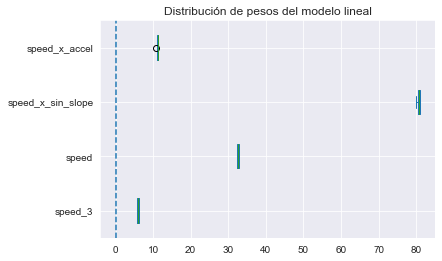

In [1292]:
import matplotlib.pyplot as plt
coefs = [
    estimator[-1].coef_ for estimator in cv_scores["estimator"]]
coefs = pd.DataFrame(coefs, columns=features)

ax = coefs.plot.box(vert=False)
ax.axvline(0, -1, 1, linestyle="--")
_ = plt.title("Distribución de pesos del modelo lineal")

Todos los pesos son mayores que 0. No es una sorpresa dado que los coeficientes están relacionados con productos de cantidades físicas positivas tales como la masa del ciclista y la bicicleta, gravedad, densidad del aire, etc. De hecho, juntando la primera ecuación y el valor de $\beta_{S}$ esperaríamos una relación que podría ser cercana a:

+ $\beta_{1} \frac{1}{2} \rho . SC_x$
+ $\beta_{2} C_r . mg$
+ $\beta_{3}  mg$
+ $\beta_{4}  ma$

Esta relación también explicaría por qué podríamos esperar que  $\beta_{1} < \beta_{2} < \beta_{3}$. De hecho, $C_r$ es una constante pequeña, por lo que podríamos esperar que $\beta_{2} < \beta_{3} . \rho . SC_x$ son valores muy pequeños en comparación con $ C_r$ o $ mg $ y uno podría esperar $\beta_{1} < \beta_{2}$.

Ahora crearemos un modelo predictivo que use todos los datos, incluyendo las medidas de los sensores disponibles, tales como la cadencia (velocidad a la que un ciclista gira los pedales medida en rotaciones por minuto) y frecuencia cardíaca (número de pulsaciones por minuto del ciclista mientras durante el ejercicio). También, usaremos un regresor no lineal, un [`sklearn.ensemble.HistGradientBoostingRegressor`](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.HistGradientBoostingRegressor.html). Estableceremos el número máximo de iteraciones en 1000 (`max_iter=1_000`) y activaremos la parada temprana (`early_stopping=True`). Repetiremos la evaluación anterior usando este regresor.

**De media, ¿cuál es el error absoluto medio en el conjunto de prueba obtenido a través de la validación cruzada?**

In [1293]:
X = cycling.drop(columns=target_name)
X["speed_3"] = X["speed"] ** 3
X["speed_x_sin_slope"] = X["speed"] * np.sin(np.arctan(X["slope"]))
X["speed_x_accel"] = X["speed"] * X["acceleration"].clip(lower=0)
X.head()

,heart-rate,cadence,speed,acceleration,slope,speed_3,speed_x_sin_slope,speed_x_accel
,,,,,,,,
2020-08-18 14:43:19,102.0,64.0,4.325,0.0880,-0.033870,80.901828,-0.146402,0.380600
2020-08-18 14:43:20,103.0,64.0,4.336,0.0842,-0.033571,81.520685,-0.145482,0.365091
2020-08-18 14:43:21,105.0,66.0,4.409,0.0234,-0.033223,85.707790,-0.146398,0.103171
2020-08-18 14:43:22,106.0,66.0,4.445,0.0016,-0.032908,87.824421,-0.146198,0.007112
2020-08-18 14:43:23,106.0,67.0,4.441,0.1144,0.000000,87.587538,0.000000,0.508050


In [1294]:
from sklearn.ensemble import HistGradientBoostingRegressor

model = make_pipeline(StandardScaler(),
                      HistGradientBoostingRegressor(max_iter=1_000,
                                                    early_stopping=True))
cv = ShuffleSplit(n_splits=4, random_state=0)
cv_scores = cross_validate(model, X, y, scoring="neg_mean_absolute_error",
                           return_estimator=True, return_train_score=True,
                           cv=cv, n_jobs=-1)
cv_scores

{'fit_time': array([1.1509881 , 1.16600084, 1.37017584, 0.85473323]),
 'score_time': array([0.04653955, 0.04804134, 0.05254531, 0.03503013]),
 'estimator': [Pipeline(steps=[('standardscaler', StandardScaler()),
                  ('histgradientboostingregressor',
                   HistGradientBoostingRegressor(early_stopping=True,
                                                 max_iter=1000))]),
  Pipeline(steps=[('standardscaler', StandardScaler()),
                  ('histgradientboostingregressor',
                   HistGradientBoostingRegressor(early_stopping=True,
                                                 max_iter=1000))]),
  Pipeline(steps=[('standardscaler', StandardScaler()),
                  ('histgradientboostingregressor',
                   HistGradientBoostingRegressor(early_stopping=True,
                                                 max_iter=1000))]),
  Pipeline(steps=[('standardscaler', StandardScaler()),
                  ('histgradientboostingregressor',

In [1295]:
print(f"MAE es: {-cv_scores['test_score'].mean():.2f} +/- "
      f"{cv_scores['test_score'].std():.2f}")

MAE es: 43.99 +/- 0.39


De media, el MAE de este modelo en el conjunto de prueba es de ~44 vatios. Por lo tanto, parece que las features adicionales y el cambio de regresor tienen un impacto positivo en el rendimiento de generalización.

**Comparando el modelo lineal y el modelo histogram gradient boosting y teniendo en cuenta el MAE de entrenamiento y prueba obtenidos a través de validación cruzada, ¿qué podemos concluir?**

Revisando las puntuaciones de entrenamiento y prueba de cada uno de los modelos, podemos concluir que:

+ el rendimiento de generalización del histogram gradient boosting está limitado por su overfitting. El error de prueba es mayor que el error de entrenamiento. Esto es síntoma de un modelo con overfitting.
+ el rendimiento de generalización del modelo lineal está limitado por su underfitting. El error de entrenamiento y prueba son muy parecidos. Sin embargo, los errores son mucho mayores que los del histogram gradient boosting. El modelo linean tiene claramente underfitting.


En la validación cruzada anterior, optamos por la opción de usar una estrategia `ShuffleSplit` de validación cruzada. Lo que significa que las muestras seleccionadas aleatoriamente se seleccionaron como conjunto de prueba, ignorando cualquier dependencia entre las líneas del dataframe.

Nos gustaría tener una estrategia de validación cruzada que evalúe la capacidad del nuestro modelo para predecir un recorrido completamente nuevo en bicicleta: las muestras del conjunto de validación sólo deben provenir de recorridos no presentes en el conjunto de entrenamiento.

**¿Cuántos recorridos en bicicleta están almacenados en el dataframe?** Ayuda: Podemos comprobar los días únicos en `DatetimeIndex` (el índice del dataframe). De hecho, podemos asumir que en un día dado, el ciclista salió como máximo una vez al día. También podemos acceder a la fecha y hora de un `DatatimeIndex` usando `df.index.date` y `df.index.time`, respectivamente.

In [1296]:
print(f"Nº de recorridos: {len(set(X.index.date))}")

Nº de recorridos: 4


In [1297]:
# otra forma
print(f"Nº de recorridos: {len(np.unique(X.index.date))}")

Nº de recorridos: 4


En lugar de usar una estrategia simple `SuffleSplit`, usaremos una estrategia que tenga en cuenta los grupos definidos por cada fecha individual. Corresponde a un recorrido en bicicleta. Nos gustaría tener una estrategia de validación cruzada que evalúe la capacidad de nuestro modelo para predecir en un recorrido completamente nuevo: las muestras en el conjunto de validación solo deben provenir de recorrides no presentes en el conjunto de entrenamiento. Por lo tanto, podemos usar una estrategia `LeaveOneGroupOut`: en cada iteración de validación cruzada mantendremos un recorrido para la evaluación y usaremos los otros recorridos para entrenar nuestro modelo.

Por tanto, necesitamos:

+ crear una variable llamda `group` que es un array unidimensional de numpy que contiene los índices de cada recorrido presente en el dataframe. Por tanto, la longitud de `group` será igual al número de muestras del dataframe. Si tuviéramos 2 recoridos, esperaríamos los índices 0 y 1 en `group` para diferenciar los recorridos. Podemos usar [`pd.factorize`](https://pandas.pydata.org/docs/reference/api/pandas.factorize.html) para codificar cualquier tipo de Python en índices enteros.
+ crear un objeto de validación cruzada llamado `cv` usando la estrategia [`sklearn.model_selection.LeaveOneGroupOut`](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.LeaveOneGroupOut.html#sklearn.model_selection.LeaveOneGroupOut).
+ evaluar tanto el modelo lineal como el histogram gradient boosting con esta estrategia.

**Usando esta evaluación y observando los errores de entrenamiento y prueba de ambos modelos, ¿qué podemos concluir?**

In [1298]:
from sklearn.model_selection import LeaveOneGroupOut

#groups = pd.factorize(np.unique(X.index.date))
groups, _ = pd.factorize(X.index.date)
cv = LeaveOneGroupOut()

model_linear = RidgeCV()
cv_scores_lineal_regression = cross_validate(
    model_linear, X_linear_model, y,
    scoring="neg_mean_absolute_error",
    groups=groups, return_estimator=True,
    return_train_score=True, cv=cv, n_jobs=-1
)

model_hgbr = HistGradientBoostingRegressor(max_iter=1_000, early_stopping=True)

cv_scores_hgbr = cross_validate(
    model_hgbr, X, y, scoring="neg_mean_absolute_error",
    groups=groups, return_estimator=True,
    return_train_score=True, cv=cv, n_jobs=-1
)

In [1299]:
-cv_scores_lineal_regression["train_score"], -cv_scores_lineal_regression["test_score"]

(array([72.43262484, 72.28760557, 68.96581013, 75.31143178]),
 array([72.44057575, 73.32215829, 81.30511116, 64.9905063 ]))

In [1300]:
-cv_scores_hgbr["train_score"], -cv_scores_hgbr["test_score"]

(array([39.46262019, 40.26826242, 38.58251339, 40.43820514]),
 array([47.74637053, 47.94907269, 53.96158726, 47.46269937]))

Revisando las puntuaciones de entrenamiento y prueba de cada uno de los modelos, podemos concluir que observamos el mismo comporamiento que con la estrategia `ShuffleSplit`, es decir:

+ el rendimiento de generalización del histogram gradient boosting está limitado por su overfitting.
+ el rendimiento de generalización del modelo lineal está limitado por su underfitting.

También observamos que histogram gradient boosting tiene claramente más overfitting con la estrategia de validación cruzada `LeaveOneGroupOut`, ya que la diferencia en las puntaciones de entrenamiento y prueba es aún mayor que la medida con la estrategia `ShuffleSplit`.

Por lo tanto, incluso si el modelo lineal está modelando el problema físico real, es probable que adolezca de deficiencias impuestas por las mediciones faltantes (por ejemplo, velocidad del viento) y por la incertidumbre de algunas medidas (por ejemplo, errores de GPS). Como resultado, el modelo lineal no es tan preciso como el regresor histogram gradient boosting que tiene acceso a mediciones externas. La información adicional, tales como la frecuencia cardíaca y la cadencia, atenúan las anteriores deficiencias.

En este caso, no podemos comparar las puntuaciones de validación cruzada partición a partición, ya que las particiones no están alineadas (no han sido generadas con la misma estrategia). En su lugar, comparemos la media de los errores de prueba de validación cruzadda en las evaluaciones del model lineal. **¿Qué podemos concluir respecto al error de prueba medio cuando usamos `ShuffleSplit` en comparación con `LeaveOneGroupOut`?**

In [1301]:
print(f"MAE es: {-cv_scores_lineal_regression['test_score'].mean():.2f} +/- "
      f"{cv_scores_lineal_regression['test_score'].std():.2f}")

MAE es: 73.01 +/- 5.78


El MAE del modelo lineal con estrategia `ShuffleSplit` era de 72.37, luego la diferencia es mínima, es decir, ambas estrategias de validación cruzada son equivalentes.

Comparemos la media de los errores de prueba de validación cruzada en las evaluaciones del modelo gradient boosting. **¿Qué podemos concluir respecto al error de prueba medio cuando usamos `ShuffleSplit` en comparación con `LeaveOneGroupOut`?**

In [1302]:
print(f"MAE es: {-cv_scores_hgbr['test_score'].mean():.2f} +/- "
      f"{cv_scores_hgbr['test_score'].std():.2f}")

MAE es: 49.28 +/- 2.71


El MAE del modelo gradient boosting con estrategia `ShuffleSplit` era de 44.22, luego la diferencia es menor por más de 3 vatios, es decir,  `ShuffleSplit` proporciona resultados demasiado optimistas. La estrategia `LeaveOneGroupOut` está más próxima a la configuración real encontrada cuando se pone el modelo en producción, por lo que podemos concluir que el rendimiento de generalización proporcionado por la estrategia de validación cruzada `ShuffleSplit` es demasiado optimista al estimar un error de prueba medio menor que el que observaríamos en recorridos futuros.

Es interesante notar que no vemos este comportamiento en el modelo lineal. La razón es que nuestro modelo lineal tiene underfitting.

Ahora entraremos en más detalle seleccionando un único recorrido para la prueba y analizando las predicciones del modelo para este recorrido de prueba. Para hacer esto, podemos reutilizar el objeto de validación cruzada `LeaveOneGroupOut` de la siguiente forma:

In [1303]:
cv = LeaveOneGroupOut()
train_indices, test_indices = list(cv.split(X, y, groups=groups))[0]

X_linear_model_train = X_linear_model.iloc[train_indices]
X_linear_model_test = X_linear_model.iloc[test_indices]

X_train = X.iloc[train_indices]
X_test = X.iloc[test_indices]

y_train = y.iloc[train_indices]
y_test = y.iloc[test_indices]

Ahora, ajustaremos tanto el modelo lineal como el modelo de histogram gradient boosting en los datos de entrenamiento y recopilaremos las predicciones en los datos de prueba. Haremos un scatter plot donde en el eje x dibujaremos las potencias medidas (objetivo real) y en el eje y dibujaremos las potencias predichas (objetivo predicho). Haremos dos gráficos separados para cada modelo. **¿Qué conclusiones podemos obtener?**

In [1304]:
from sklearn.metrics import mean_absolute_error

model_linear.fit(X_train, y_train)
y_pred = model_linear.predict(X_test)
print(f"MAE: "
      f"{mean_absolute_error(y_test, y_pred):.3f} k$")

MAE: 61.469 k$


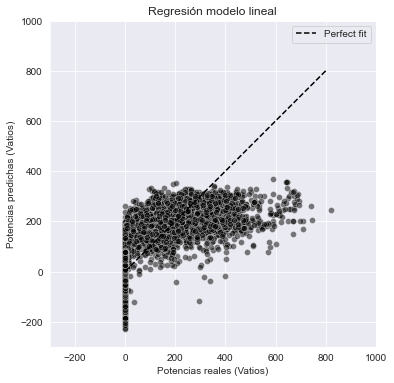

In [1305]:
predicted_actual = {
    "Potencias reales (Vatios)": y_test, "Potencias predichas (Vatios)": y_pred}
predicted_actual = pd.DataFrame(predicted_actual)

plt.figure(figsize=(6, 6))
sns.scatterplot(data=predicted_actual,
                x="Potencias reales (Vatios)", y="Potencias predichas (Vatios)",
                color="black", alpha=0.5)
#plt.axline((0, 0), slope=1, label="Perfect fit")
plt.plot([0, 800], [0, 800], color="black", linestyle="--",
         label="Perfect fit")
plt.axis('square')
plt.xlim(-300, 1000)
plt.ylim(-300, 1000)
plt.legend()
_ = plt.title("Regresión modelo lineal")

In [1306]:
from sklearn.metrics import mean_absolute_error

model_hgbr.fit(X_train, y_train)
y_pred = model_hgbr.predict(X_test)
print(f"MAE: "
      f"{mean_absolute_error(y_test, y_pred):.3f} k$")

MAE: 47.833 k$


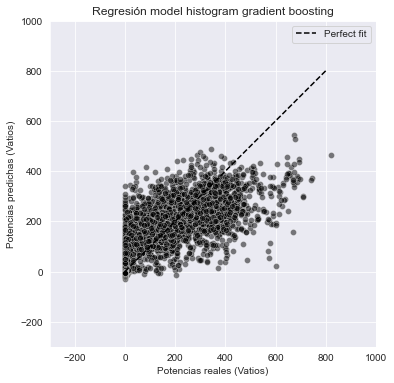

In [1307]:
predicted_actual = {
    "Potencias reales (Vatios)": y_test, "Potencias predichas (Vatios)": y_pred}
predicted_actual = pd.DataFrame(predicted_actual)

plt.figure(figsize=(6, 6))
sns.scatterplot(data=predicted_actual,
                x="Potencias reales (Vatios)", y="Potencias predichas (Vatios)",
                color="black", alpha=0.5)
#plt.axline((0, 0), slope=1, label="Perfect fit")
plt.plot([0, 800], [0, 800], color="black", linestyle="--",
         label="Perfect fit")
plt.axis('square')
plt.xlim(-300, 1000)
plt.ylim(-300, 1000)
plt.legend()
_ = plt.title("Regresión model histogram gradient boosting")

Comencemos mirando las muestras con potencias altas. Vemos que tanto el modelo lineal como el regresor histogram gradient boosting predicen siempre potencias por debajo de las mediciones reales. Las muestras de altas potencias corresponden con esfuerzos en sprints. Al medir la velocidad y la aceleración, existe una especie de retardo para observar este cambio mientras que medir directamente la potencia aplicada en los pedales no se ve afectado por este problema.

Por otro lado, vemos que el modelo lineal predice una potencia negativa catastrófica para muestras con una potencia de 0 vatios. Este se debe a nuestro modelado. De hecho, la potencia basada en el cambio de energía cinética (potencia necesaria para acelerar o desacelerar) está produciendo tales artefactos. No estamos modelando la pérdida de potencia introducida por la disipación de calor cuando los frenos reducen la velocidad de la bicicleta (para tomar una curva, por ejemplo) y, por tanto, obtenemos valores sin sentido para muestras con baja potencia. El regresor histogram gradient boosting usa en su lugar la cadencia, ya que 0 rpm (revoluciones por minuto) se corresponderá con 0 vatios producidos.

Ahora seleccionaremos una porción de los datos de prueba usando el siguiente código:

In [1308]:
time_slice = slice("2020-08-18 17:00:00", "2020-08-18 17:05:00")

X_test_linear_model_subset = X_linear_model_test[time_slice]
X_test_subset = X_test[time_slice]
y_test_subset = y_test[time_slice]

Permite seleccionar datos desde la 5.00 pm hasta las 5.05 pm. Usaremos los anteriores modelos ya entrenados (lineal y grandient boosting) para predecir en esta porción de los datos de prueba. Dibujaremos en el mismo gráfico los datos reales y las predicciones de cada modelo. **¿Qué conclusiones podemos obtener?**

In [1309]:
y_pred_linear_model = model_linear.predict(X_test_subset)
print(f"MAE modelo lineal: "
      f"{mean_absolute_error(y_test_subset, y_pred_linear_model):.3f} k$")

y_pred_hgbr = model_hgbr.predict(X_test_subset)
print(f"MAE hgbr: "
      f"{mean_absolute_error(y_test_subset, y_pred_hgbr):.3f} k$")

MAE modelo lineal: 61.359 k$
MAE hgbr: 52.386 k$


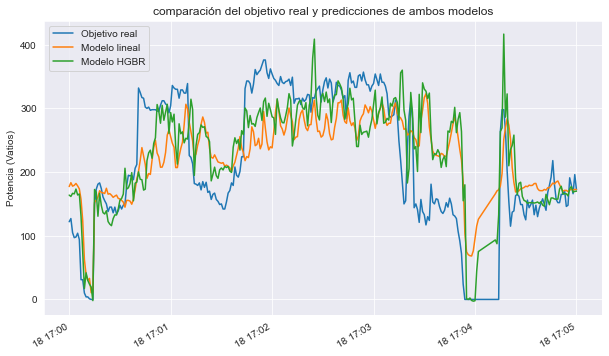

In [1310]:
ax = y_test_subset.plot(label="Objetivo real", figsize=(10, 6))
ax.plot(y_test_subset.index, y_pred_linear_model,
        label="Modelo lineal")
ax.plot(y_test_subset.index, y_pred_hgbr, label="Modelo HGBR")
ax.set_ylabel("Potencia (Vatios)")
plt.legend()
_ = plt.title("comparación del objetivo real y predicciones de ambos modelos")

Vemos que el modelo lineal tiene predicciones que están más alejadas del objetivo real que las predicciones del regresor histogram gradient boosting. Mientras que histogram gradient boosting es capaz de hacer cambios abruptos de potencia, el modelo lineal es incapaz de predecir dichos cambios y necesita tiempo para generar el nivel de potencia real.

Una vez mas, el rendimiento comparativamente malo del modelo de regresión lineal entrenado en las features físicamente significativas no se deriva necesariamente de errores en la ingeniería de características sino que podría de errores de medición que impiden una estimación precisa de cambios pequeños en la velocidad y aceleración.

El modelo gradient boosting sería capar de solucionar estas limitaciones de los errores de GPS a través de mediciones más precisas de frecuencia cardíaca y cadencia.